# Data Description

## Data Source

* PUBG Match Deaths and Statistics, Kaggle 
    \- https://www.kaggle.com/skihikingkevin/pubg-match-deaths

## Data Introduction

In this Kaggle Dataset, over 720,000 competitive matches from the popular game PlayerUnknown's Battlegrounds. The data was extracted from pubg.op.gg, a game tracker website.


### PlayerUnknown's Battlegrounds

PUBG is a first/third-person shooter battle royale style game that matches over 90 players on a large island where teams and players fight to the death until one remains. Players are airdropped from an airplane onto the island where they are to scavenge towns and buildings for weapons, ammo, armor and first-aid. Players will then decide to either fight or hide with the ultimate goal of being the last one standing. A bluezone (see below) will appear a few minutes into the game to corral players closer and closer together by dealing damage to anyone that stands within the bluezone and sparing whoever is within the safe zone.


### The Dataset

This dataset provides two zips: aggregate and deaths.

In **deaths**, the files record every death that occurred within the 720k matches. That is, each row documents an event where a player has died in the match.

In **aggregate**, each match's meta information and player statistics are summarized (as provided by pubg). It includes various aggregate statistics such as player kills, damage, distance walked, etc as well as metadata on the match itself such as queue size, fpp/tpp, date, etc.
The uncompressed data is divided into 5 chunks of approximately 2gb each.

### Columns in deaths

1. killed_by: Which weapon is killed
1. killer_name: Killer game id
1. killer_placement: The final ranking of the team where the killer is located
1. killer_position_x: X coordinate of the killer when the killing behavior occurs
1. killer_position_y: Y coordinate of the killer when the killing behavior occurs
1. map: Game Map(Erangel island/ Miramar desert)
1. match_id : Event Unique ID
1. time: When the kill occurs(How many seconds after the game starts)
1. victim_name: The killed game id
1. victim_position_x: X coordinate of the person being killed when the killing occurs
1. victim_position_y: Y coordinate of the killer at the time of the killing behavior

### Columns in aggregate

1. date: Start time of the game
1. game_size: Site size
1. match_id: Event Unique ID
1. match_mode: Game Mode(First/ Third Person View)
1. party_size: Squad size(1person/ 2people/ 4people)
1. player_assists: Rescue teammates
1. player_dbno: Number of times the player was knocked down
1. player_dist_ride: Driving Distance
1. player_dist_walk: Walking distance
1. player_dmg: Injury points
1. player_kills: kills
1. player_name: Player Game id
1. player_survive_time: Player survival time
1. team_id: The player's team number
1. team_placement: The final ranking of the player's team

# 라이브러리 및 데이터 로드

## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm.auto import tqdm
tqdm.pandas()
import os

In [2]:
# MAC 기준
# Window font: 'Malgun Gothic'

plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 데이터

In [4]:
data_dir = '../dataset/raw/'

In [4]:
def data_load(data_dir, name_list, df_list):
    df_list = []
    for i in tqdm(name_list):
        df_list.append(pd.read_csv(data_dir + i))
    return df_list

In [6]:
agg_data_dir = '../dataset/raw/aggregate/'
agg_name_list = sorted(os.listdir(agg_data_dir))
agg_list = []
agg_list = data_load(agg_data_dir, agg_name_list, agg_list)

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
deaths_data_dir = '../dataset/raw/deaths/'
deaths_name_list = sorted(os.listdir(deaths_data_dir))
deaths_list = []
deaths_list = data_load(deaths_data_dir, deaths_name_list, deaths_list)

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
def get_shape(df_list):
    for i in df_list:
        print(i.shape)

In [9]:
get_shape(agg_list)

(13849287, 15)
(13844275, 15)
(13841504, 15)
(13840680, 15)
(11993485, 15)


In [10]:
get_shape(deaths_list)

(13426348, 12)
(13440889, 12)
(13431052, 12)
(13431331, 12)
(11640855, 12)


# Data preprocessing

## Aggregate의 na 제거

In [11]:
def df_drop_na(df_list):
    for i in tqdm(range(len(df_list))):
        df_list[i] = df_list[i].dropna()

In [12]:
df_drop_na(agg_list)

  0%|          | 0/5 [00:00<?, ?it/s]

## match_mode 제거
* 모두 'tpp'만 가짐

In [13]:
def del_col(df_list, col_name):
    for i in tqdm(df_list):
        del i[col_name]

In [14]:
del_col(agg_list, 'match_mode')

  0%|          | 0/5 [00:00<?, ?it/s]

## 두 데이터에서 매칭되지 않는 match_id 제거

In [15]:
def get_unique_match_id(df_list):
    match_id = []
    for i in df_list:
        match_id += [x for x in i['match_id'].unique()]
    return match_id

In [16]:
agg_match_id = get_unique_match_id(agg_list)

In [17]:
len(agg_match_id)

729969

In [18]:
deaths_match_id = get_unique_match_id(deaths_list)

In [19]:
agg_mat = set(agg_match_id)
deaths_mat = set(deaths_match_id)

In [20]:
len(agg_mat), len(deaths_mat), len(agg_mat & deaths_mat)

(729969, 722425, 722396)

In [21]:
get_shape(deaths_list)

(13426348, 12)
(13440889, 12)
(13431052, 12)
(13431331, 12)
(11640855, 12)


In [22]:
for i in range(len(deaths_list)):
    deaths_list[i] = deaths_list[i][deaths_list[i]['match_id'].isin(agg_match_id)]

In [23]:
get_shape(deaths_list)

(13425912, 12)
(13440074, 12)
(13430252, 12)
(13430868, 12)
(11640760, 12)


## deaths data na 처리

### map na 처리

In [24]:
deaths_list[0]['map'].unique()

array(['MIRAMAR', 'ERANGEL', nan], dtype=object)

* map 결측값 대체 가능 여부 확인

In [25]:
map_na_match_id = []
for i in deaths_list:
    map_na_match_id += [x for x in i.loc[i['map'].isnull(), 'match_id'].unique()]

In [26]:
E_match_id = []
for i in deaths_list:
    E_match_id += [x for x in i.loc[i['map'] == 'ERANGEL', 'match_id'].unique()]

In [27]:
M_match_id = []
for i in deaths_list:
    M_match_id += [x for x in i.loc[i['map'] == 'MIRAMAR', 'match_id'].unique()]

* 겹치는 match_id 확인

In [28]:
map_na_match_id = set(map_na_match_id)
E_match_id = set(E_match_id)
M_match_id = set(M_match_id)

In [29]:
len(map_na_match_id & E_match_id), len(map_na_match_id & M_match_id), len(E_match_id & M_match_id) 

(0, 0, 0)

* 대체 불가능 판단 -> Drop

In [30]:
get_shape(deaths_list)

(13425912, 12)
(13440074, 12)
(13430252, 12)
(13430868, 12)
(11640760, 12)


### deaths 데이터 na drop

In [31]:
df_drop_na(deaths_list)

  0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
get_shape(deaths_list)

(12100006, 12)
(12116443, 12)
(12108530, 12)
(12101869, 12)
(10494810, 12)


## Data 병합

* key columns
    * agg.match_id = deaths.match_id
    * agg.player_name = deaths.killer_name

In [33]:
# key column의 이름을 맞춰야 함
# deaths의 killer_name을 player_name으로 변경

def chg_col_names(df_list, col_names):
    for i in tqdm(df_list):
        i.columns = col_names

In [34]:
deaths_list[0].columns

Index(['killed_by', 'killer_name', 'killer_placement', 'killer_position_x',
       'killer_position_y', 'map', 'match_id', 'time', 'victim_name',
       'victim_placement', 'victim_position_x', 'victim_position_y'],
      dtype='object')

In [35]:
deaths_cols = ['killed_by', 'player_name', 'killer_placement', 'killer_position_x',
               'killer_position_y', 'map', 'match_id', 'time', 'victim_name',
               'victim_placement', 'victim_position_x', 'victim_position_y']

In [36]:
# key column 이름 맞추기

chg_col_names(deaths_list, deaths_cols)

  0%|          | 0/5 [00:00<?, ?it/s]

## Aggregate 데이터와 Deaths 데이터 Merge

* 같은 번호의 데이터와 짝을 이루는 것을 match_id로 확인함
    * e.g. agg_0는 deaths_0과 Merge

In [37]:
get_shape(agg_list)

(13829038, 14)
(13824209, 14)
(13821505, 14)
(13820791, 14)
(11976035, 14)


In [38]:
get_shape(deaths_list)

(12100006, 12)
(12116443, 12)
(12108530, 12)
(12101869, 12)
(10494810, 12)


In [39]:
deaths_list[0]['map'].unique()

array(['MIRAMAR', 'ERANGEL'], dtype=object)

In [40]:
def get_merged_df(left, right, join, keys):
    df_list = []
    for i in tqdm(range(len(left))):
        df_list.append(pd.merge(left[i], right[i], how=join, on=keys))
    return df_list

In [41]:
df_merge = get_merged_df(agg_list, deaths_list, 'left', ['match_id', 'player_name'])

  0%|          | 0/5 [00:00<?, ?it/s]

In [42]:
get_shape(df_merge)

(20122234, 24)
(20125055, 24)
(20116444, 24)
(20111666, 24)
(17431740, 24)


## map 채우기

In [43]:
def fill_map_na(df_list, match_id_list, map_name):
    for i in df_list:
        i.loc[(i['match_id'].isin(match_id_list))&(i['map'].isnull()), 'map'] = map_name
    return df_list

In [44]:
match_id = [E_match_id, M_match_id]
map_names = ['ERANGEL', 'MIRAMAR']

for i in tqdm(range(len(match_id))):
    df_merge = fill_map_na(df_merge, match_id[i], map_names[i])

  0%|          | 0/2 [00:00<?, ?it/s]

## map별로 데이터 나누기

* ERANGEL과 MIRAMAR로 데이터 셋을 나눔

In [45]:
def get_df_map(df_list, map_name):
    df_map = []
    for i in df_list:
        df_map.append(i[i['map'] == map_name])
    return df_map

In [46]:
df_map  = []
for i in tqdm(range(len(map_names))):
    df_map.append(get_df_map(df_merge, map_names[i]))

  0%|          | 0/2 [00:00<?, ?it/s]

## party_size 별로 데이터 나누기

* party_size에 따라 Tier가 다르기 때문에 데이터를 분리함

In [47]:
def get_df_party_size(df_list, party_size):
    df_party_size = []
    for i in df_list:
        df_party_size.append(i[i['party_size'] == party_size])
    return df_party_size

In [48]:
df = []
party_size = [1, 2, 4]

for i in tqdm(range(len(party_size))):
    for j in range(len(df_map)):
        df.append(get_df_party_size(df_map[j], party_size[i]))

  0%|          | 0/3 [00:00<?, ?it/s]

In [49]:
# df[0]: solo, ERANGEL / df[1]: solo, MIRAMAR
# df[2]: duo, ERANGEL / df[3]: duo, MIRAMAR
# df[4]: squad, ERANGEL / df[5]: squad, MIRAMAR

len(df)

6

## party_size별 map별 dataset 합치기

In [50]:
def get_concat(df_list):
    df_concat = []
    for i in tqdm(range(len(df_list))):
        df_concat.append(pd.concat(df_list[i], ignore_index=True))
    return df_concat

In [51]:
# df_concat[0]: solo, ERANGEL / df_concat[1]: solo, MIRAMAR
# df_concat[2]: duo, ERANGEL / df_concat[3]: duo, MIRAMAR
# df_concat[4]: squad, ERANGEL / df_concat[5]: squad, MIRAMAR

df_concat = get_concat(df)

  0%|          | 0/6 [00:00<?, ?it/s]

## killed_by 그룹핑

In [52]:
def killed_by_refine(df):
    df['killed_by'] = df['killed_by'].replace({'death.WeapSawnoff_C': 'sawed_off', 
                                               'death.PlayerMale_A_C': 'Punch',
                                               'death.PG117_A_01_C': 'Boat' , 'death.RedZoneBomb_C': 'RedZone'})
    df['killed_by'] = df['killed_by'].replace(['Pickup Truck','Hit by Car','Buggy','Dacia','Motorbike',
                                               'Motorbike (SideCar)','Uaz','Van'], 'land_vehicle')
    df['killed_by'] = df['killed_by'].replace(['death.ProjMolotov_C', 'death.ProjMolotov_DamageField_C', 
                                               'death.Buff_FireDOT_C'], 'Molotov')
    df['killed_by'] = df['killed_by'].replace(['Aquarail','Boat'], 'water_vehicle')

In [53]:
for i in tqdm(df_concat):
    killed_by_refine(i)

  0%|          | 0/6 [00:00<?, ?it/s]

## csv로 내보내기

In [54]:
def df_read_csv(df_list, data_dir, file_name):
    for i in tqdm(range(len(df_list))):
        df_list[i].to_csv(data_dir + f'{file_name[i]}.csv', index=False)

In [55]:
# data_dir = '../dataset/preprocessing/'
# file_name = ['solo_E', 'solo_M', 'duo_E', 'duo_M', 'squad_E', 'squad_M']

# df_read_csv(df_concat, data_dir, file_name)

# Outlier 처리

In [56]:
data_dir = '../dataset/preprocessing/'
name_list = ['solo_E.csv', 'solo_M.csv', 'duo_E.csv', 'duo_M.csv', 'squad_E.csv', 'squad_M.csv']
df_prep = []

df_prep = data_load(data_dir, name_list, df_prep)

  0%|          | 0/6 [00:00<?, ?it/s]

In [57]:
# df_prep[0]: solo, ERANGEL / df_prep[1]: solo, MIRAMAR
# df_prep[2]: duo, ERANGEL / df_prep[3]: duo, MIRAMAR
# df_prep[4]: squad, ERANGEL / df_prep[5]: squad, MIRAMAR

get_shape(df_prep)

(17105104, 24)
(3096664, 24)
(25881722, 24)
(5208521, 24)
(36231117, 24)
(8886496, 24)


In [59]:
df_prep_raw = df_prep.copy()

##  Outlier 처리

In [60]:
class CheckingOutlier:
    
    '''
    Outlier 처리를 위한 Class 입니다.
    아래의 기준에 만족하는 데이터만 사용합니다.
    
    game_size : solo  - 80 이상
                duo   - 40 이상
                squad - 20 이상
    dist_ride : 30000(30km) 이하
    dist_walk : 10000(10km) 이하
    kills :     30 kill 이하
    dmg :       3000 damage 이하
    kill_dist : 40000(400m) 이하
    dbno :      duo/squad : 11 이하
    survive_time : 1900 이하
    
    '''
    
    def game_size(self, df):
        if df['party_size'].unique() == 1:
            df = df.loc[df['game_size'] >= 80]
        elif df['party_size'].unique() == 2:
            df = df.loc[df['game_size'] >= 40]
        else:
            df = df.loc[df['game_size'] >= 20]
        return df
        
    def player_dist_ride(self, df):
        df = df.loc[df['player_dist_ride'] <= 30000]
        return df
    
    def player_dist_walk(self, df):
        df = df.loc[df['player_dist_walk'] <= 10000]
        return df
        
    def player_kills(self, df):
        df = df.drop(df.loc[df['player_kills'] > 30].index)
        return df
    
    def player_dmg(self, df):
        df = df.drop(df.loc[df['player_dmg'] > 3000].index)  
        return df
        
    def kill_dist(self, df):
        df['kill_dist'] = np.sqrt(((df['killer_position_x'] - df['victim_position_x']) ** 2) 
                                      + ((df['killer_position_y'] - df['victim_position_y']) ** 2))
        df = df.drop(df.loc[df['kill_dist'] > 40000].index)
        return df    
    
    def player_dbno(self, df):
        if df['party_size'].unique() != 1 :
            df = df.drop(df.loc[df['player_dbno'] > 11].index)
        else:
            del df['player_dbno']
        return df
    
    def player_survive_time(self, df):
        df = df.drop(df.loc[df['player_survive_time'] > 1900].index)
        return df


In [61]:
def check_outlier(df_list):
    new_df_list = []
    checker = CheckingOutlier()
    
    for df in tqdm(df_list):
        filtered_df = pd.DataFrame()
        filtered_df = checker.game_size(df)
        filtered_df = checker.player_dist_ride(filtered_df)
        filtered_df = checker.player_dist_walk(filtered_df)
        filtered_df = checker.player_kills(filtered_df)
        filtered_df = checker.player_dmg(filtered_df)
        filtered_df = checker.kill_dist(filtered_df)
        filtered_df = checker.player_dbno(filtered_df)
        filtered_df = checker.player_survive_time(filtered_df)
        new_df_list.append(filtered_df)
            
    return new_df_list

In [62]:
df_outlier = check_outlier(df_prep)

  0%|          | 0/6 [00:00<?, ?it/s]

In [63]:
len(df_outlier)

6

## 분석 Dataset 확인

In [64]:
get_shape(df_outlier)

(15529329, 24)
(2774102, 24)
(23746180, 25)
(4811630, 25)
(33634137, 25)
(8459496, 25)


In [65]:
df_outlier[0].describe()

,game_size,party_size,player_assists,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,15529329.000,15529329.000,15529329.000,15529329.000,15529329.000,15529329.000,15529329.000,15529329.000,15529329.000,15529329.000,9281916.000,9281916.000,9281916.000,9281916.000,9281916.000,9281916.000,9281916.000,9281916.000
mean,94.145,1.000,0.083,1198.681,1412.183,219.510,1.982,884.385,100048.477,40.725,27.775,418461.120,401912.214,646.641,50.955,418420.859,401917.367,3692.370
std,3.820,0.000,0.297,1888.731,1278.337,284.101,2.822,592.924,28.656,28.447,22.672,133349.631,133552.786,514.490,26.272,133331.960,133539.105,5552.157
min,80.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,100000.000,1.000,1.000,0.000,0.000,54.000,1.000,0.000,0.000,0.000
25%,93.000,1.000,0.000,0.000,255.443,15.000,0.000,288.539,100024.000,15.000,8.000,342957.875,313910.000,192.000,29.000,342747.800,313922.375,489.734
50%,95.000,1.000,0.000,0.000,1132.727,120.000,1.000,837.009,100048.000,37.000,22.000,420837.300,388478.900,468.000,52.000,420832.900,388325.350,1326.656
75%,97.000,1.000,0.000,1999.271,2267.761,306.000,3.000,1455.983,100073.000,64.000,44.000,513957.200,483439.700,1041.000,73.000,513906.425,483376.400,4334.539
max,100.000,1.000,6.000,26844.410,9999.756,2999.000,30.000,1899.997,100123.000,100.000,100.000,810680.300,795355.900,2043.000,100.000,810731.300,795355.900,39999.820


In [66]:
df_outlier[1].describe()

,game_size,party_size,player_assists,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,2774102.000,2774102.000,2774102.000,2774102.000,2774102.000,2774102.000,2774102.000,2774102.000,2774102.000,2774102.000,1651476.000,1651476.000,1651476.000,1651476.000,1651476.000,1651476.000,1651476.000,1651476.000
mean,88.884,1.000,0.086,935.574,1503.940,208.863,1.866,865.527,100048.879,38.930,26.793,401590.365,386609.854,635.126,48.027,401582.858,386660.772,3563.017
std,4.040,0.000,0.302,1634.272,1376.435,249.272,2.454,595.675,28.631,27.105,21.908,117995.763,120679.986,519.330,25.037,117966.552,120675.556,5268.857
min,80.000,1.000,0.000,0.000,0.000,0.000,0.000,7.035,100000.000,1.000,1.000,15872.990,6278.910,52.000,2.000,15577.670,6278.910,0.000
25%,86.000,1.000,0.000,0.000,240.400,17.000,0.000,265.279,100024.000,14.000,8.000,339604.125,290852.150,177.000,27.000,339534.900,290878.100,557.875
50%,89.000,1.000,0.000,0.000,1165.673,122.000,1.000,809.603,100049.000,36.000,21.000,386578.800,394520.900,442.000,49.000,386603.000,394781.650,1464.438
75%,92.000,1.000,0.000,1410.627,2496.854,304.000,3.000,1438.948,100073.000,62.000,42.000,471153.225,449065.300,1036.000,69.000,471132.025,449418.725,4051.782
max,100.000,1.000,4.000,29583.578,9980.483,2997.000,30.000,1899.998,100123.000,100.000,97.000,813956.900,794637.700,2175.000,100.000,813956.900,794637.700,39995.778


In [67]:
df_outlier[2].describe()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,23746180.000,23746180.000,23746180.000,23746180.000,23746180.000,23746180.000,23746180.000,23746180.000,23746180.000,23746180.000,23746180.000,13990108.000,13990108.000,13990108.000,13990108.000,13990108.000,13990108.000,13990108.000,13990108.000
mean,48.463,2.000,0.312,1.122,1430.228,1464.938,229.483,1.973,910.126,25.633,21.781,16.340,420516.755,399931.461,681.192,26.707,420468.867,399945.373,3889.295
std,1.836,0.000,0.668,1.482,1995.739,1265.687,276.390,2.642,598.094,14.544,14.484,12.875,141635.418,137940.693,526.307,13.551,141632.388,137927.825,5685.473
min,40.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,-19185.750,0.000,56.000,1.000,-19152.120,0.000,0.000
25%,48.000,2.000,0.000,0.000,0.000,305.229,28.000,0.000,312.484,13.000,9.000,5.000,341441.475,302957.000,215.000,15.000,341272.900,302913.700,467.307
50%,49.000,2.000,0.000,1.000,2.008,1217.608,141.000,1.000,858.220,26.000,20.000,13.000,421279.300,384973.600,497.000,28.000,421234.800,384827.100,1481.699
75%,50.000,2.000,0.000,2.000,2550.786,2356.003,325.000,3.000,1489.412,38.000,34.000,26.000,534345.000,488226.500,1100.000,38.000,534141.925,488121.125,4734.488
max,51.000,2.000,12.000,11.000,29835.404,9999.921,2922.000,29.000,1900.000,259.000,51.000,51.000,810635.500,795290.900,2139.000,51.000,810741.600,795290.900,39999.931


In [68]:
df_outlier[3].describe()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,4811630.000,4811630.000,4811630.000,4811630.000,4811630.000,4811630.000,4811630.000,4811630.000,4811630.000,4811630.000,4811630.000,2826537.000,2826537.000,2826537.000,2826537.000,2826537.000,2826537.000,2826537.000,2826537.000
mean,45.409,2.000,0.301,1.082,1145.735,1565.676,220.447,1.892,891.940,25.304,20.615,15.674,402334.310,383253.214,671.351,25.019,402327.403,383304.759,3670.173
std,2.312,0.000,0.647,1.386,1788.881,1372.825,252.851,2.435,599.074,14.344,13.674,12.287,124230.538,126641.243,529.594,12.793,124195.400,126639.479,5422.205
min,40.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,34.979,1.000,1.000,1.000,0.000,0.000,56.000,1.000,0.000,0.000,0.000
25%,44.000,2.000,0.000,0.000,0.000,297.855,31.000,0.000,293.626,13.000,8.000,5.000,340336.100,284578.300,203.000,14.000,340272.800,284715.400,507.195
50%,46.000,2.000,0.000,1.000,0.000,1257.736,141.000,1.000,829.055,25.000,19.000,13.000,384451.400,392215.100,479.000,26.000,384518.300,392410.700,1513.973
75%,47.000,2.000,0.000,2.000,1915.102,2600.285,319.000,3.000,1481.069,38.000,32.000,25.000,467651.700,446776.100,1092.000,36.000,467559.100,446909.200,4244.406
max,50.000,2.000,10.000,11.000,27013.408,9911.751,2636.000,26.000,1899.991,51.000,50.000,50.000,814274.400,815168.200,1961.000,50.000,814274.400,815209.600,39998.010


In [69]:
df_outlier[4].describe()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,33634137.000,33634137.000,33634137.000,33634137.000,33634137.000,33634137.000,33634137.000,33634137.000,33634137.000,33634137.000,33634137.000,19413218.000,19413218.000,19413218.000,19413218.000,19413218.000,19413218.000,19413218.000,19413218.000
mean,27.072,4.000,0.428,1.575,1548.984,1566.911,223.694,1.866,952.007,14.305,12.665,10.520,415637.171,399062.842,734.870,15.322,415583.509,399102.291,4230.786
std,1.550,0.000,0.813,1.976,2073.794,1298.067,259.929,2.450,598.798,8.062,8.019,7.713,145048.372,141667.872,538.429,7.601,145036.993,141634.218,6164.485
min,20.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,-71095.730,-70411.010,23.000,1.000,-71107.960,-70481.330,0.000
25%,26.000,4.000,0.000,0.000,0.000,370.799,28.000,0.000,354.622,7.000,5.000,4.000,337058.125,292824.800,251.000,9.000,337128.000,292902.100,421.243
50%,27.000,4.000,0.000,1.000,270.279,1351.052,138.000,1.000,919.731,14.000,12.000,9.000,420132.300,387496.950,562.000,16.000,420106.100,387305.800,1525.617
75%,28.000,4.000,1.000,2.000,2784.403,2508.737,322.000,3.000,1520.011,21.000,20.000,17.000,532393.600,492339.450,1195.000,22.000,532268.900,492338.700,5289.262
max,35.000,4.000,13.000,11.000,29940.578,9994.319,2913.000,23.000,1900.000,58.000,35.000,35.000,810724.700,795259.900,2182.000,35.000,810775.600,795266.100,39999.922


In [70]:
df_outlier[5].describe()

,game_size,party_size,player_assists,player_dbno,player_dist_ride,player_dist_walk,player_dmg,player_kills,player_survive_time,team_id,team_placement,killer_placement,killer_position_x,killer_position_y,time,victim_placement,victim_position_x,victim_position_y,kill_dist
count,8459496.000,8459496.000,8459496.000,8459496.000,8459496.000,8459496.000,8459496.000,8459496.000,8459496.000,8459496.000,8459496.000,4896952.000,4896952.000,4896952.000,4896952.000,4896952.000,4896952.000,4896952.000,4896952.000
mean,26.320,4.000,0.410,1.532,1192.951,1659.250,216.653,1.816,924.838,14.332,12.343,10.326,400294.117,381762.295,713.422,14.840,400281.942,381834.683,3878.018
std,1.845,0.000,0.780,1.874,1819.230,1403.438,242.838,2.323,598.579,8.092,7.851,7.538,129132.034,129327.307,537.057,7.435,129077.837,129305.249,5828.257
min,20.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,55.000,1.000,0.000,0.000,0.000
25%,25.000,4.000,0.000,0.000,0.000,364.515,33.000,0.000,332.304,7.000,5.000,4.000,341038.675,283633.575,235.000,8.000,341049.350,283745.975,437.270
50%,26.000,4.000,0.000,1.000,0.000,1364.649,139.000,1.000,867.135,14.000,12.000,9.000,381076.500,399491.450,534.000,15.000,381187.050,399737.900,1452.226
75%,28.000,4.000,1.000,2.000,2026.560,2743.640,316.000,3.000,1498.834,21.000,19.000,16.000,467907.625,451936.225,1158.000,21.000,467845.125,452228.025,4533.824
max,36.000,4.000,10.000,11.000,29290.750,9984.742,2345.000,21.000,1900.000,37.000,36.000,36.000,805065.800,815183.800,2025.000,36.000,805171.500,815183.800,39999.363


## Dataset 분리하기

* Outlier를 제거한 데이터셋과 Outlier만 모은 데이터셋으로 분리

In [71]:
def seperating_dataset(df_raw_list, df_in_list):
    df_in = []
    df_out = []
    
    for i in tqdm(range(len(df_in_list))):
        in_idx = []
        in_idx = list(df_in_list[i].index)
        max_idx = max(df_in_list[i].index)
        out_idx = []
        out_idx = list(set(list(range(max_idx))) - set(in_idx))
        df_in.append(df_in_list[i].reset_index(drop=True))
        df_out.append(df_raw_list[i].loc[out_idx].reset_index(drop=True))
    return df_in, df_out

In [72]:
df_in, df_out = seperating_dataset(df_prep, df_outlier)

  0%|          | 0/6 [00:00<?, ?it/s]

In [73]:
get_shape(df_in)

(15529329, 24)
(2774102, 24)
(23746180, 25)
(4811630, 25)
(33634137, 25)
(8459496, 25)


In [74]:
get_shape(df_out)

(1575775, 24)
(322559, 24)
(2135542, 24)
(396891, 24)
(2596980, 24)
(427000, 24)


## csv로 내보내기

In [241]:
# data_dir = '../dataset/outlier/'
# in_file_name = ['solo_E_in', 'solo_M_in', 'duo_E_in', 'duo_M_in', 'squad_E_in', 'squad_M_in']
# out_file_name = ['solo_E_out', 'solo_M_out', 'duo_E_out', 'duo_M_out', 'squad_E_out', 'squad_M_out']

# df_read_csv(df_in, data_dir, in_file_name)
# df_read_csv(df_out, data_dir, out_file_name)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# play_count 10회 이상인 player 선택
* 분석을 위해 play 횟수가 10회 이상인 player만 선택

In [76]:
data_dir = '../dataset/outlier/'
in_file_name = ['solo_E_in', 'solo_M_in', 'duo_E_in', 'duo_M_in', 'squad_E_in', 'squad_M_in']
in_file_list = list(map(lambda x: x + '.csv', in_file_name))

In [77]:
df_outlier  = data_load(data_dir, in_file_list, df)

  0%|          | 0/6 [00:00<?, ?it/s]

In [244]:
# party_size별로 데이터 concat으로 합치기

df_concat = []
for i in tqdm(range(len(df_outlier))):
    if i % 2 == 1:
        continue
    df_concat.append(pd.concat([df_outlier[i], df_outlier[i+1]], ignore_index=True))

  0%|          | 0/6 [00:00<?, ?it/s]

In [245]:
def get_df_play_count(df_list):
    df_play_count = []
    for df in tqdm(df_list):
        play_count = []
        play_count = df.groupby('player_name')['match_id'].nunique().to_frame()
        play_count_idx = play_count.loc[play_count['match_id'] >= 10].index
        df_play_count.append(df.loc[df['player_name'].isin(play_count_idx)])
    return df_play_count

In [246]:
df_play_count = get_df_play_count(df_concat)

  0%|          | 0/3 [00:00<?, ?it/s]

## csv로 내보내기

In [247]:
data_dir = '../dataset/play_count/'
file_name = ['solo', 'duo', 'squad']

df_read_csv(df_play_count, data_dir, file_name)

  0%|          | 0/3 [00:00<?, ?it/s]

# 파생변수 생성

In [5]:
data_dir = '../dataset/play_count/'
name_list = ['solo.csv', 'duo.csv', 'squad.csv']
df_play_count = []

df_play_count = data_load(data_dir, name_list, df_play_count)

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
class DerivedVariable:
    
    '''
    파생변수를 만드는 Class 입니다.
    아래의 방법으로 파생변수를 생성하였습니다.
    
    date         : dtype을 datetime 으로 변환
    score        : (rank_point * 1) + (kill * 2) + (assist * 2)
    tier         : score column을 바탕으로 구함. squad의 +0.6은 위치를 맞추기 위한 수평이동
    KDA          : kill, assist, death를 이용해 파생변수 생성 
                   death는 match 합계에서 team_placement가 1등인 횟수를 제외하여 계산
    num_of_match : player별 총 게임 횟수를 계산
    
    '''
    
    def date(self, df):
        df.loc[:, 'date'] = pd.to_datetime(df['date'])
        return df
    
    def score(self, df):
        # player 별 score 
        if df['party_size'].unique() == 1 :
            df.loc[:, 'each_game_score'] = (100 - df['team_placement'])*1 + df['player_kills']*2 + df['player_assists']*2
        elif df['party_size'].unique() == 2 :
            df.loc[:, 'each_game_score'] = (50 - df['team_placement'])*1 + df['player_kills']*2 + df['player_assists']*2
        else:
            df.loc[:, 'each_game_score'] = (36 - df['team_placement'])*1 + df['player_kills']*2 + df['player_assists']*2
        
        # score의 sum 
        score = df.groupby(['player_name', 'match_id'])['each_game_score'].mean().to_frame()
        total_score = score.groupby('player_name')['each_game_score'].sum().to_frame()
        total_score.columns = ['total_score']
        df['total_score'] = total_score.loc[df['player_name'], 'total_score'].values
        
        return df
    
    def tier(self, df):
        # score의 합의 log scailing과 squad의 그래프 수평이동
        if df['party_size'].unique() == 4 :
            df.loc[:, 'total_score_log'] = np.log(df['total_score']) + 0.6
        else:
            df.loc[:, 'total_score_log'] = np.log(df['total_score']) 
        
        # tier 부여(1: Bronze, 2: Silver, 3: Gold, 4: Platinum, 5: Diamond, 6: Master)
        def get_tier(score):
            if score < 6:
                return 1
            elif score < 6.75:
                return 2
            elif score < 7.5:
                return 3
            elif score < 8.25:
                return 4
            elif score < 9:
                return 5
            else:
                return 6
        
        df.loc[:, 'tier'] = df['total_score_log'].apply(lambda x: get_tier(x))

        return df
    
    def kda_num_of_match(self, df):
        # 필요한 column 만 추출
        anal_col = df[['player_name', 'match_id','team_placement', 'player_kills', 'player_assists']]

        # num_of_match
        num_of_match = anal_col.groupby('player_name')['match_id'].nunique().reset_index()
        num_of_match.columns = ['player_name', 'num_of_match']

        # num_of_1st
        num_of_1st = anal_col[anal_col['team_placement'] == 1].groupby('player_name')['match_id'].nunique().reset_index()
        num_of_1st.columns = ['player_name', 'num_of_1st']

        # death 
        temp = num_of_match.merge(num_of_1st, how = 'left', on = 'player_name')
        temp = temp.fillna(0)
        temp.loc[:, 'deaths_sum'] = temp['num_of_match'] - temp['num_of_1st']
        death = temp[['player_name', 'deaths_sum']]

        # kill & assist
        KA_count = anal_col.groupby(['player_name', 'match_id'])[['player_kills', 'player_assists']].mean().reset_index()
        KA_sum = KA_count.groupby('player_name')[['player_kills', 'player_assists']].sum().reset_index()
        KA_sum.columns = ['player_name', 'kills_sum', 'assists_sum']

        # KDA
        KDA = KA_sum.merge(death, how = 'left', on = 'player_name')
        KDA.loc[:, 'kda'] = (KDA['kills_sum'] + KDA['assists_sum']) / KDA['deaths_sum']
        KDA_1 = KDA[['player_name', 'kda']]


        ## 여기 한번에 표현 할 수 있는가
        df = df.merge(KDA_1, how='left', on='player_name')
        df = df.merge(num_of_match, how='left', on='player_name' )

        return df

## 파생변수 생성

In [7]:
def variables(df_list):
    new_df_list = []
    variables = DerivedVariable()
    
    for df in tqdm(df_list):
        filtered_df = pd.DataFrame()
        filtered_df = variables.date(df)
        filtered_df = variables.score(df)
        filtered_df = variables.tier(df)
        filtered_df = variables.kda_num_of_match(df)
        new_df_list.append(filtered_df)
            
    return new_df_list

In [8]:
df_vars = variables(df_play_count)

  0%|          | 0/3 [00:00<?, ?it/s]

## 분석 데이터 선택

In [251]:
df_vars_raw = df_vars.copy()

In [252]:
for i in tqdm(range(len(df_vars))):
    df_vars[i] = df_vars[i].groupby(['player_name', 'match_id']).mean().reset_index()

  0%|          | 0/3 [00:00<?, ?it/s]

In [253]:
for i in tqdm(range(len(df_vars))):
    df_vars[i] = df_vars[i].groupby(['player_name']).mean().reset_index(drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [254]:
cols_solo = ['player_kills', 'player_dmg', 'player_assists', 'kda', 'player_dist_walk', 
             'player_dist_ride', 'kill_dist', 'player_survive_time', 'team_placement',  'num_of_match', 'tier']
cols = ['player_kills', 'player_dmg', 'player_assists', 'player_dbno', 'kda', 'player_dist_walk', 
        'player_dist_ride', 'kill_dist', 'player_survive_time', 'team_placement',  'num_of_match', 'tier']

In [255]:
for i in tqdm(range(len(df_vars))):
    if df_vars[i]['party_size'].unique() != 1:
        df_vars[i] = df_vars[i][cols]
    else:
        df_vars[i] = df_vars[i][cols_solo]
    df_vars[i]['kill_dist'] = df_vars[i]['kill_dist'].fillna(0)

  0%|          | 0/3 [00:00<?, ?it/s]

## csv로 내보내기

In [256]:
data_dir = '../dataset/tier_diff/'
file_name = ['tier_diff_solo', 'tier_diff_duo', 'tier_diff_squad']

df_read_csv(df_vars, data_dir, file_name)

  0%|          | 0/3 [00:00<?, ?it/s]

# Tier별 차이 검정

In [401]:
import scipy.stats as stats
import scikit_posthocs as sp

In [402]:
data_dir = '../dataset/tier_diff/'
name_list = ['tier_diff_solo.csv', 'tier_diff_duo.csv', 'tier_diff_squad.csv']
df_tier_diff = []

df_tier_diff = data_load(data_dir, name_list, df_tier_diff)

  0%|          | 0/3 [00:00<?, ?it/s]

In [403]:
def get_tier_df(df):
    tier_df_list = []   
    for i in range(1, 7):
        tier_df_list.append(df.loc[df['tier'] == i])
    return tier_df_list

In [404]:
class TierDiffTest():
    
    def normality(self, df_list, col_name):
        normality = []
        for df in df_list:
            tier_normality = stats.anderson(df['player_kills'], dist='norm')
            normality.append((tier_normality[0] < tier_normality[1][2]))
        return normality

    def kruskal(self, df_list, col_name):
        k = stats.kruskal(df_list[0][col_name],
                          df_list[1][col_name],
                          df_list[2][col_name],
                          df_list[3][col_name],
                          df_list[4][col_name],
                          df_list[5][col_name])
        return k[1]
        
    def multiple_comparison(self, df, col_name):
        comparison = pd.DataFrame()
        comparison = sp.posthoc_conover(df, val_col = col_name, group_col = 'tier', p_adjust = 'holm')
        return comparison

## Solo

In [405]:
solo = df_tier_diff[0]

In [406]:
solo_tier = get_tier_df(solo)

In [407]:
solo.corr().style.background_gradient(cmap='Blues')

,player_kills,player_dmg,player_assists,kda,player_dist_walk,player_dist_ride,kill_dist,player_survive_time,team_placement,num_of_match,tier
player_kills,1.000000,0.977121,0.224431,0.939409,0.187901,0.160341,0.307732,0.171913,-0.168125,-0.041299,0.033379
player_dmg,0.977121,1.000000,0.275021,0.919011,0.202658,0.187820,0.320386,0.192250,-0.191757,-0.041252,0.040836
player_assists,0.224431,0.275021,1.000000,0.280370,0.057871,0.126409,0.095645,0.072946,-0.068099,0.000050,0.029733
kda,0.939409,0.919011,0.280370,1.000000,0.191460,0.168808,0.306126,0.184927,-0.176929,-0.039211,0.034792
player_dist_walk,0.187901,0.202658,0.057871,0.191460,1.000000,0.435994,0.309220,0.854516,-0.848391,-0.081539,0.175048
player_dist_ride,0.160341,0.187820,0.126409,0.168808,0.435994,1.000000,0.224417,0.605633,-0.579612,-0.002392,0.174684
kill_dist,0.307732,0.320386,0.095645,0.306126,0.309220,0.224417,1.000000,0.302050,-0.288040,-0.043465,0.054933
player_survive_time,0.171913,0.192250,0.072946,0.184927,0.854516,0.605633,0.302050,1.000000,-0.956581,-0.064344,0.224931
team_placement,-0.168125,-0.191757,-0.068099,-0.176929,-0.848391,-0.579612,-0.288040,-0.956581,1.000000,0.057924,-0.248533
num_of_match,-0.041299,-0.041252,0.000050,-0.039211,-0.081539,-0.002392,-0.043465,-0.064344,0.057924,1.000000,0.776733


In [408]:
solo.groupby('tier').median()

,player_kills,player_dmg,player_assists,kda,player_dist_walk,player_dist_ride,kill_dist,player_survive_time,team_placement,num_of_match
tier,,,,,,,,,,
1.000,0.500,70.100,0.000,0.545,456.543,207.435,1257.194,369.497,67.300,10.000
2.000,0.714,94.636,0.053,0.786,981.464,661.746,2160.716,651.360,51.077,12.000
3.000,0.750,98.750,0.053,0.812,1101.314,831.203,2471.125,726.394,47.000,21.000
4.000,0.711,94.574,0.056,0.773,1061.001,848.066,2456.337,708.610,47.706,44.000
5.000,0.683,91.750,0.057,0.744,1050.796,890.270,2423.211,712.595,47.253,89.000
6.000,0.692,93.264,0.058,0.750,1046.817,930.899,2386.333,726.285,46.494,186.000


In [409]:
def checking_tier_diff(df, df_tier, check_columns):
        checker = TierDiffTest()
        normality = {}
        kruskal = {}
        comparison = {}
        
        for col in tqdm(check_columns):
            normality[col] = checker.normality(df_tier, col)
            kruskal[col] = checker.kruskal(df_tier, col)
            comparison[col] = checker.multiple_comparison(df, col).style.background_gradient(cmap='Blues')
        
        return normality, kruskal, comparison

In [410]:
check_cols = solo.groupby('tier').mean().columns

solo_n, solo_k, solo_c = checking_tier_diff(solo, solo_tier, check_cols)

  0%|          | 0/10 [00:00<?, ?it/s]

In [411]:
# 정규성 검정 결과

solo_n

{'player_kills': [False, False, False, False, False, False],
 'player_dmg': [False, False, False, False, False, False],
 'player_assists': [False, False, False, False, False, False],
 'kda': [False, False, False, False, False, False],
 'player_dist_walk': [False, False, False, False, False, False],
 'player_dist_ride': [False, False, False, False, False, False],
 'kill_dist': [False, False, False, False, False, False],
 'player_survive_time': [False, False, False, False, False, False],
 'team_placement': [False, False, False, False, False, False],
 'num_of_match': [False, False, False, False, False, False]}

In [412]:
# Kruskal-Wallis 검정 결과

solo_k

{'player_kills': 0.0,
 'player_dmg': 0.0,
 'player_assists': 0.0,
 'kda': 0.0,
 'player_dist_walk': 0.0,
 'player_dist_ride': 0.0,
 'kill_dist': 0.0,
 'player_survive_time': 0.0,
 'team_placement': 0.0,
 'num_of_match': 0.0}

### player_kills

In [413]:
def get_tier_median(df, col):
    return df.groupby('tier')[col].median().to_frame()

In [414]:
get_tier_median(solo, 'player_kills')

,player_kills
tier,
1.000,0.500
2.000,0.714
3.000,0.750
4.000,0.711
5.000,0.683
6.000,0.692


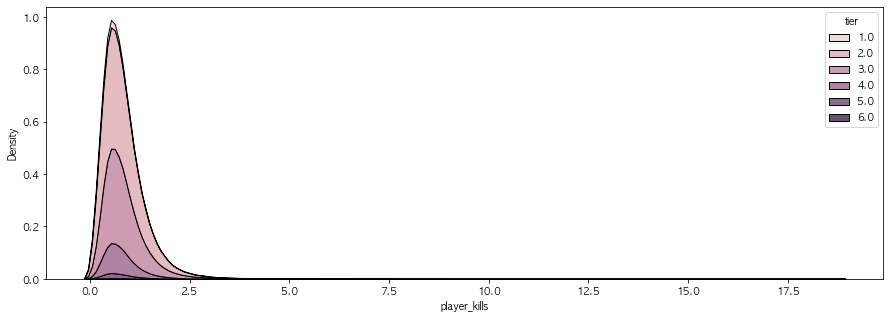

In [415]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=solo, x='player_kills', hue='tier', multiple='stack')

In [416]:
solo_c['player_kills']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,1.000000,0.000019,0.631564
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.002327
4.0,0.000000,1.000000,0.000000,1.000000,0.000032,0.631564
5.0,0.000000,0.000019,0.000000,0.000032,1.000000,1.000000
6.0,0.000000,0.631564,0.002327,0.631564,1.000000,1.000000


### player_dmg

In [417]:
get_tier_median(solo, 'player_dmg')

,player_dmg
tier,
1.000,70.100
2.000,94.636
3.000,98.750
4.000,94.574
5.000,91.750
6.000,93.264


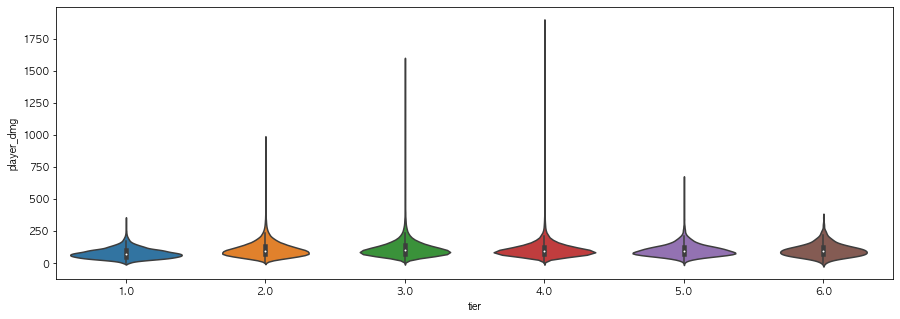

In [418]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=solo, x='tier', y='player_dmg')

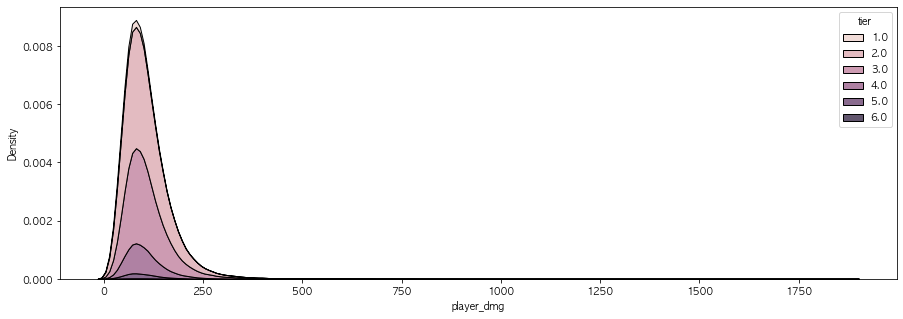

In [419]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=solo, x='player_dmg', hue='tier', multiple='stack')

In [420]:
solo_c['player_dmg']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.102749,0.001057,0.543941
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.002628
4.0,0.000000,0.102749,0.000000,1.000000,0.000057,0.466755
5.0,0.000000,0.001057,0.000000,0.000057,1.000000,0.877728
6.0,0.000000,0.543941,0.002628,0.466755,0.877728,1.000000


### player_assists

In [421]:
get_tier_median(solo, 'player_assists')

,player_assists
tier,
1.000,0.000
2.000,0.053
3.000,0.053
4.000,0.056
5.000,0.057
6.000,0.058


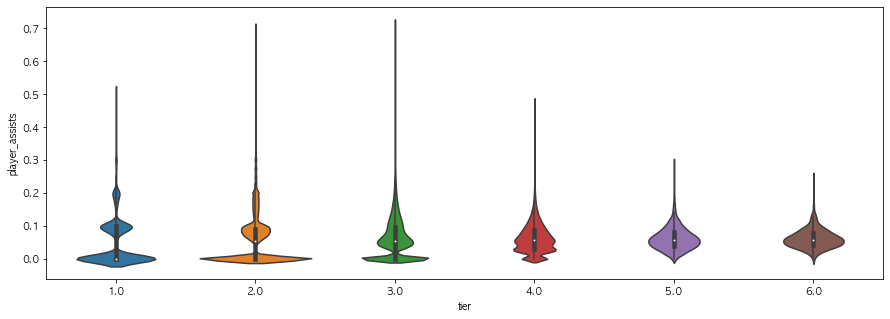

In [422]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=solo, x='tier', y='player_assists')

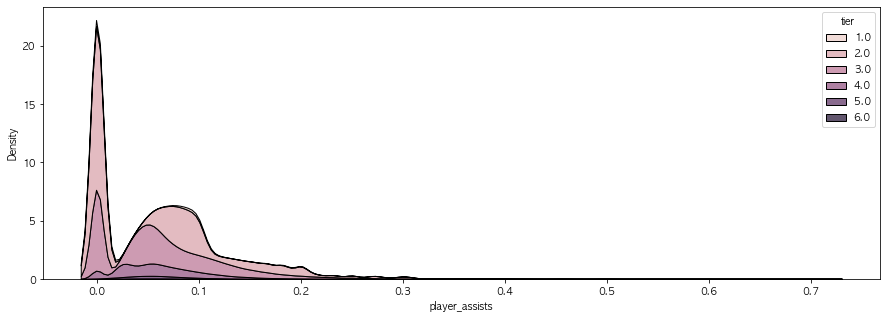

In [423]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=solo, x='player_assists', hue='tier', multiple='stack')

In [424]:
solo_c['player_assists']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.023276
4.0,0.000000,0.000000,0.000000,1.000000,0.288851,1.000000
5.0,0.000000,0.000000,0.000000,0.288851,1.000000,1.000000
6.0,0.000000,0.000000,0.023276,1.000000,1.000000,1.000000


### kda

In [425]:
get_tier_median(solo, 'kda')

,kda
tier,
1.000,0.545
2.000,0.786
3.000,0.812
4.000,0.773
5.000,0.744
6.000,0.750


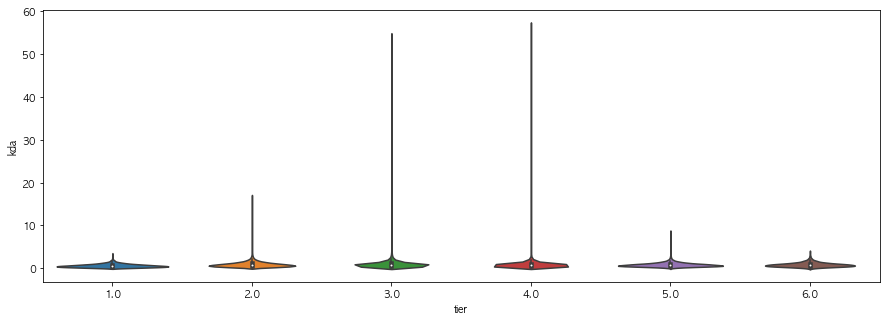

In [426]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=solo, x='tier', y='kda')

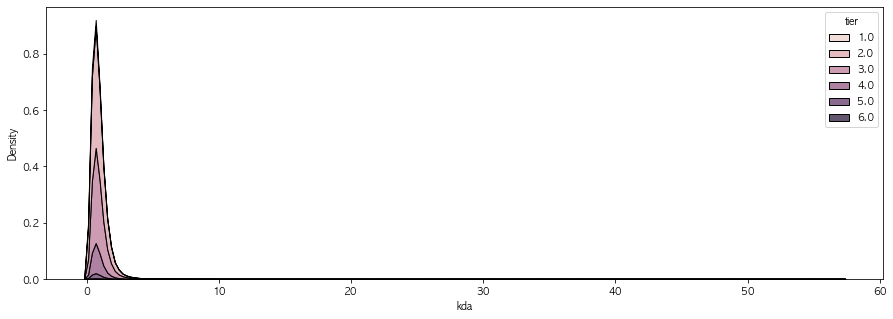

In [427]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=solo, x='kda', hue='tier', multiple='stack')

In [428]:
solo_c['kda']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.438520,0.000332,0.462454
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.002867
4.0,0.000000,0.438520,0.000000,1.000000,0.000057,0.462454
5.0,0.000000,0.000332,0.000000,0.000057,1.000000,0.881097
6.0,0.000000,0.462454,0.002867,0.462454,0.881097,1.000000


### player_dist_walk

In [429]:
get_tier_median(solo, 'player_dist_walk')

,player_dist_walk
tier,
1.000,456.543
2.000,981.464
3.000,1101.314
4.000,1061.001
5.000,1050.796
6.000,1046.817


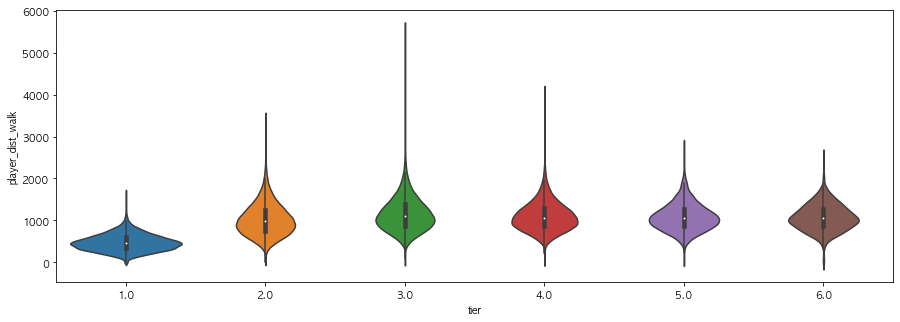

In [430]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=solo, x='tier', y='player_dist_walk')

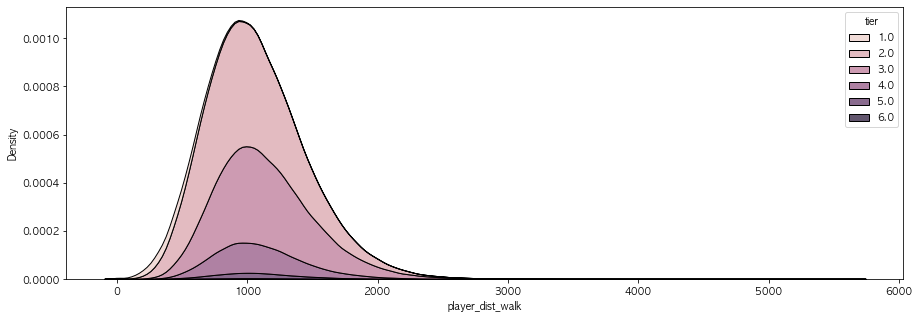

In [431]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=solo, x='player_dist_walk', hue='tier', multiple='stack')

In [432]:
solo_c['player_dist_walk']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000028
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.003175
4.0,0.000000,0.000000,0.000000,1.000000,0.276568,0.831365
5.0,0.000000,0.000000,0.000000,0.276568,1.000000,0.835042
6.0,0.000000,0.000028,0.003175,0.831365,0.835042,1.000000


### player_dist_ride

In [433]:
get_tier_median(solo, 'player_dist_ride')

,player_dist_ride
tier,
1.000,207.435
2.000,661.746
3.000,831.203
4.000,848.066
5.000,890.270
6.000,930.899


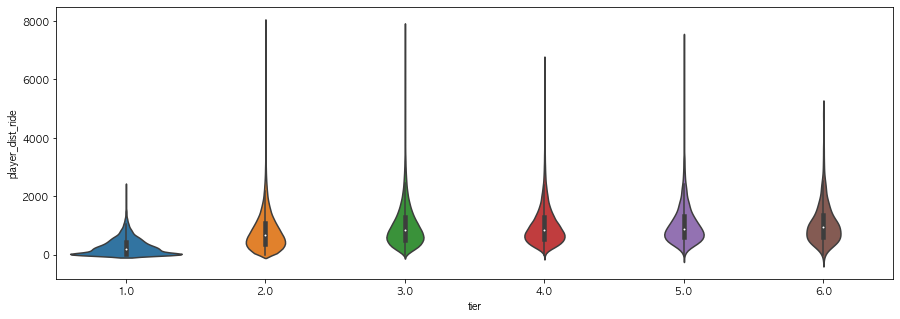

In [434]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=solo, x='tier', y='player_dist_ride')

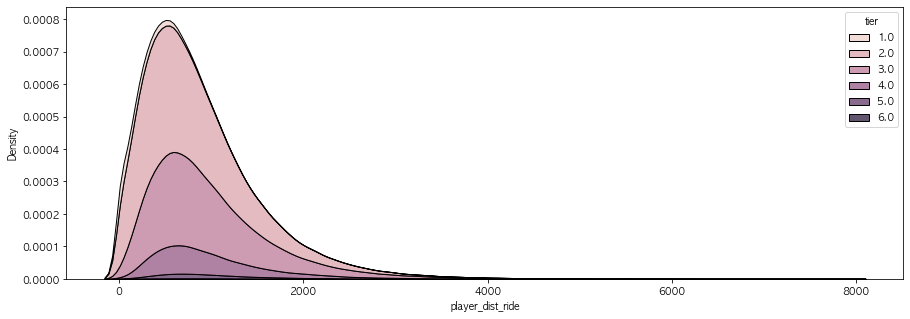

In [435]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=solo, x='player_dist_ride', hue='tier', multiple='stack')

In [436]:
solo_c['player_dist_ride']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000259
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.018352
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.559988
6.0,0.000000,0.000000,0.000259,0.018352,0.559988,1.000000


### kill_dist

In [437]:
get_tier_median(solo, 'kill_dist')

,kill_dist
tier,
1.000,1257.194
2.000,2160.716
3.000,2471.125
4.000,2456.337
5.000,2423.211
6.000,2386.333


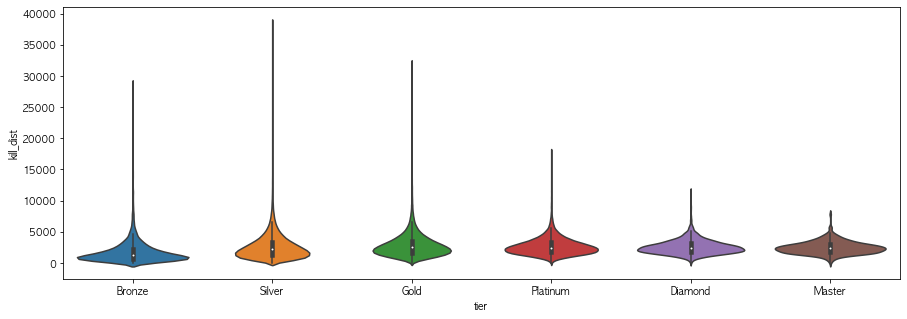

In [438]:
plt.figure(figsize=(15,5))
sns.violinplot(data=solo, x='tier', y='kill_dist')
_ = plt.xticks(np.arange(6), ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master'])

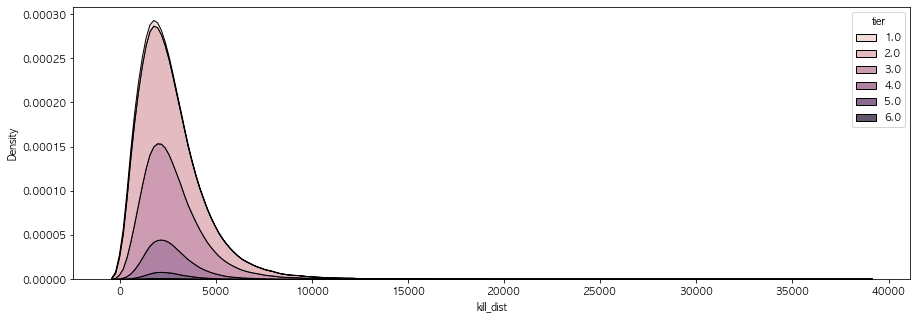

In [439]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=solo, x='kill_dist', hue='tier', multiple='stack')

In [440]:
solo_c['kill_dist']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.015469
3.0,0.000000,0.000000,1.000000,0.723010,0.452849,0.452849
4.0,0.000000,0.000000,0.723010,1.000000,0.452849,0.452849
5.0,0.000000,0.000000,0.452849,0.452849,1.000000,0.521804
6.0,0.000000,0.015469,0.452849,0.452849,0.521804,1.000000


### player_survive_time

In [441]:
get_tier_median(solo, 'player_survive_time')

,player_survive_time
tier,
1.000,369.497
2.000,651.360
3.000,726.394
4.000,708.610
5.000,712.595
6.000,726.285


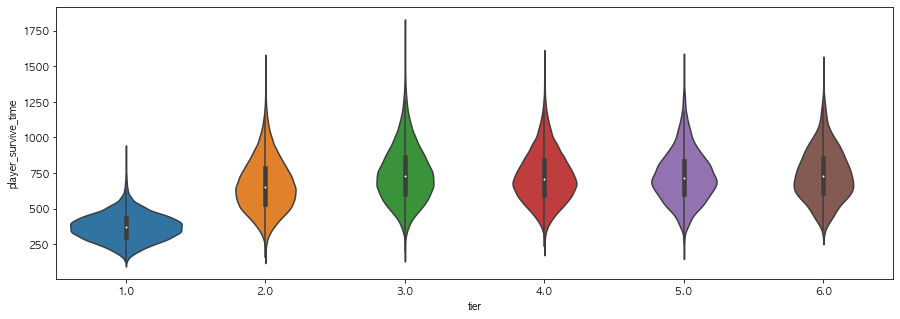

In [442]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=solo, x='tier', y='player_survive_time')

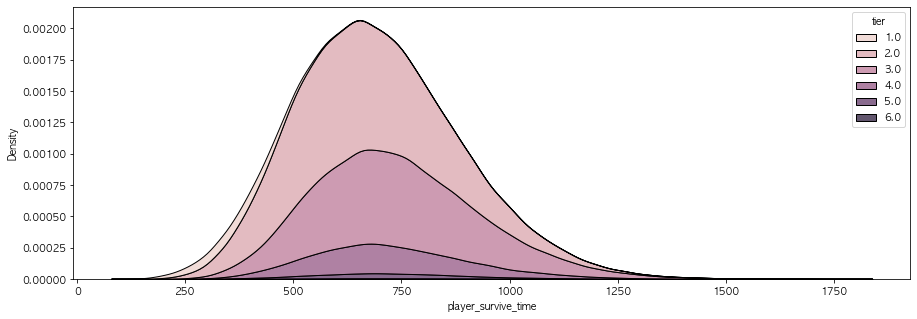

In [443]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=solo, x='player_survive_time', hue='tier', multiple='stack')

In [444]:
solo_c['player_survive_time']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000259,0.922600
4.0,0.000000,0.000000,0.000000,1.000000,0.545998,0.261462
5.0,0.000000,0.000000,0.000259,0.545998,1.000000,0.490491
6.0,0.000000,0.000000,0.922600,0.261462,0.490491,1.000000


### team_placement

In [445]:
get_tier_median(solo, 'team_placement')

,team_placement
tier,
1.000,67.300
2.000,51.077
3.000,47.000
4.000,47.706
5.000,47.253
6.000,46.494


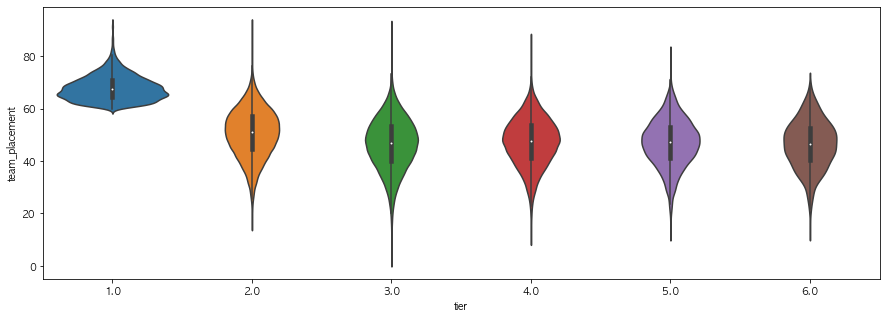

In [446]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=solo, x='tier', y='team_placement')

In [447]:
solo_c['team_placement']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.110280,0.429670
4.0,0.000000,0.000000,0.000000,1.000000,0.110280,0.110280
5.0,0.000000,0.000000,0.110280,0.110280,1.000000,0.285786
6.0,0.000000,0.000000,0.429670,0.110280,0.285786,1.000000


### num_of_match

In [448]:
get_tier_median(solo, 'num_of_match')

,num_of_match
tier,
1.000,10.000
2.000,12.000
3.000,21.000
4.000,44.000
5.000,89.000
6.000,186.000


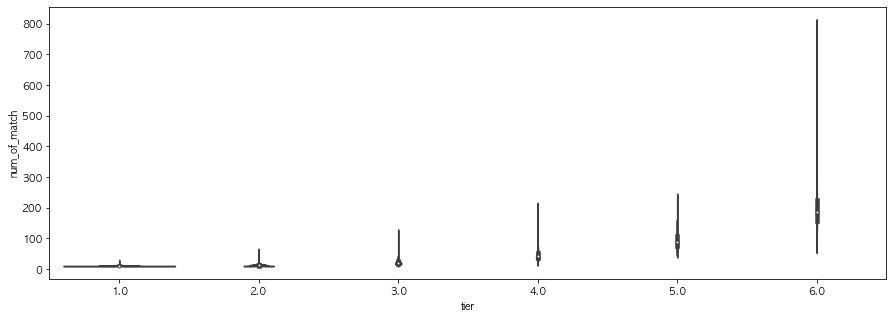

In [449]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=solo, x='tier', y='num_of_match')

In [450]:
solo_c['num_of_match']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.090190
6.0,0.000000,0.000000,0.000000,0.000000,0.090190,1.000000


## Duo

In [451]:
duo = df_tier_diff[1]

In [453]:
duo_tier = get_tier_df(duo)

In [454]:
duo.corr().style.background_gradient(cmap='Blues')

,player_kills,player_dmg,player_assists,player_dbno,kda,player_dist_walk,player_dist_ride,kill_dist,player_survive_time,team_placement,num_of_match,tier
player_kills,1.000000,0.954257,0.407881,0.920787,0.947421,0.250205,0.124500,0.233143,0.232653,-0.227531,0.012739,0.140243
player_dmg,0.954257,1.000000,0.460522,0.928578,0.920551,0.276766,0.161029,0.257100,0.267721,-0.261751,0.014817,0.151094
player_assists,0.407881,0.460522,1.000000,0.364590,0.567572,0.227936,0.165668,0.179422,0.242717,-0.232999,0.009816,0.112450
player_dbno,0.920787,0.928578,0.364590,1.000000,0.867298,0.210188,0.110536,0.208245,0.191598,-0.189125,0.015049,0.127838
kda,0.947421,0.920551,0.567572,0.867298,1.000000,0.279741,0.157265,0.251736,0.271085,-0.263557,0.006568,0.141772
player_dist_walk,0.250205,0.276766,0.227936,0.210188,0.279741,1.000000,0.481692,0.321440,0.862827,-0.823014,-0.072573,0.154386
player_dist_ride,0.124500,0.161029,0.165668,0.110536,0.157265,0.481692,1.000000,0.232593,0.669671,-0.615923,-0.011174,0.162199
kill_dist,0.233143,0.257100,0.179422,0.208245,0.251736,0.321440,0.232593,1.000000,0.329410,-0.314220,-0.029337,0.072227
player_survive_time,0.232653,0.267721,0.242717,0.191598,0.271085,0.862827,0.669671,0.329410,1.000000,-0.915198,-0.053644,0.200135
team_placement,-0.227531,-0.261751,-0.232999,-0.189125,-0.263557,-0.823014,-0.615923,-0.314220,-0.915198,1.000000,0.055913,-0.215619


In [455]:
duo.groupby('tier').median()

,player_kills,player_dmg,player_assists,player_dbno,kda,player_dist_walk,player_dist_ride,kill_dist,player_survive_time,team_placement,num_of_match
tier,,,,,,,,,,,
1.000,0.667,99.385,0.167,0.462,0.857,1034.782,872.725,2280.561,675.840,26.909,12.000
2.000,0.812,117.238,0.207,0.545,1.048,1194.965,1103.835,2880.650,766.940,24.433,20.000
3.000,0.840,121.125,0.212,0.568,1.071,1158.060,1116.022,2922.930,753.733,24.800,41.000
4.000,0.897,127.237,0.223,0.596,1.139,1136.630,1128.528,2922.688,749.568,24.859,82.000
5.000,0.904,126.993,0.223,0.598,1.140,1123.544,1106.568,2895.726,750.351,24.876,170.000
6.000,0.787,114.464,0.199,0.566,1.025,1125.339,972.556,2855.483,731.760,25.646,360.000


In [456]:
check_cols = duo.groupby('tier').mean().columns

duo_n, duo_k, duo_c = checking_tier_diff(duo, duo_tier, check_cols)

  0%|          | 0/11 [00:00<?, ?it/s]

In [457]:
# 정규성 검정 결과

duo_n

{'player_kills': [False, False, False, False, False, False],
 'player_dmg': [False, False, False, False, False, False],
 'player_assists': [False, False, False, False, False, False],
 'player_dbno': [False, False, False, False, False, False],
 'kda': [False, False, False, False, False, False],
 'player_dist_walk': [False, False, False, False, False, False],
 'player_dist_ride': [False, False, False, False, False, False],
 'kill_dist': [False, False, False, False, False, False],
 'player_survive_time': [False, False, False, False, False, False],
 'team_placement': [False, False, False, False, False, False],
 'num_of_match': [False, False, False, False, False, False]}

In [458]:
# Kruskal-Wallis 검정 결과

duo_k

{'player_kills': 0.0,
 'player_dmg': 0.0,
 'player_assists': 0.0,
 'player_dbno': 0.0,
 'kda': 0.0,
 'player_dist_walk': 0.0,
 'player_dist_ride': 0.0,
 'kill_dist': 0.0,
 'player_survive_time': 0.0,
 'team_placement': 0.0,
 'num_of_match': 0.0}

### player_kills

In [459]:
get_tier_median(duo, 'player_kills')

,player_kills
tier,
1.000,0.667
2.000,0.812
3.000,0.840
4.000,0.897
5.000,0.904
6.000,0.787


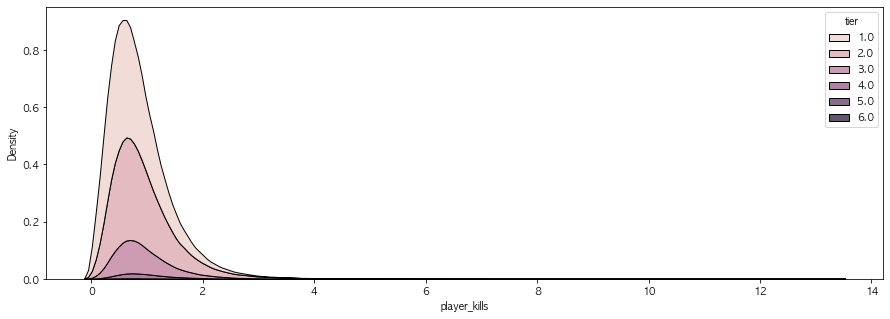

In [460]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='player_kills', hue='tier', multiple='stack')

In [461]:
duo_c['player_kills']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.002164
2.0,0.000000,1.000000,0.000000,0.000000,0.000001,1.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.004578,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.000001,0.004578,1.000000,1.000000,1.000000
6.0,0.002164,1.000000,1.000000,1.000000,1.000000,1.000000


### player_dmg

In [462]:
get_tier_median(duo, 'player_dmg')

,player_dmg
tier,
1.000,99.385
2.000,117.238
3.000,121.125
4.000,127.237
5.000,126.993
6.000,114.464


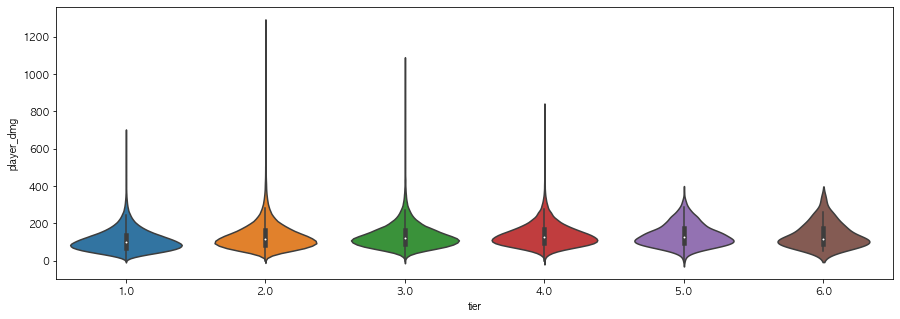

In [463]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=duo, x='tier', y='player_dmg')

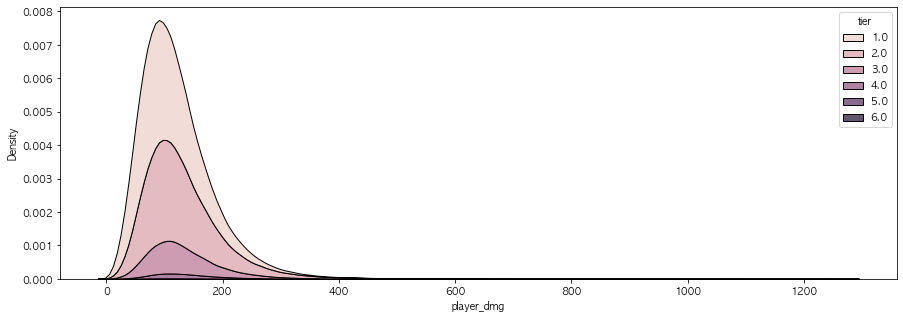

In [464]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='player_dmg', hue='tier', multiple='stack')

In [465]:
duo_c['player_dmg']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.002829
2.0,0.000000,1.000000,0.000000,0.000000,0.000004,1.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.025790,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.000004,0.025790,1.000000,1.000000,1.000000
6.0,0.002829,1.000000,1.000000,1.000000,1.000000,1.000000


### player_assists

In [466]:
get_tier_median(duo, 'player_assists')

,player_assists
tier,
1.000,0.167
2.000,0.207
3.000,0.212
4.000,0.223
5.000,0.223
6.000,0.199


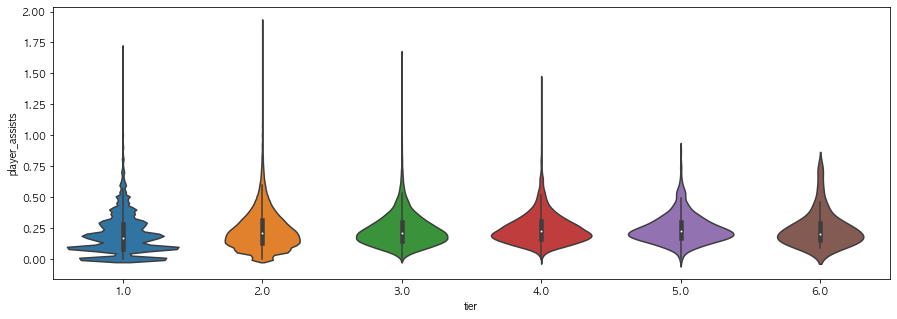

In [467]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=duo, x='tier', y='player_assists')

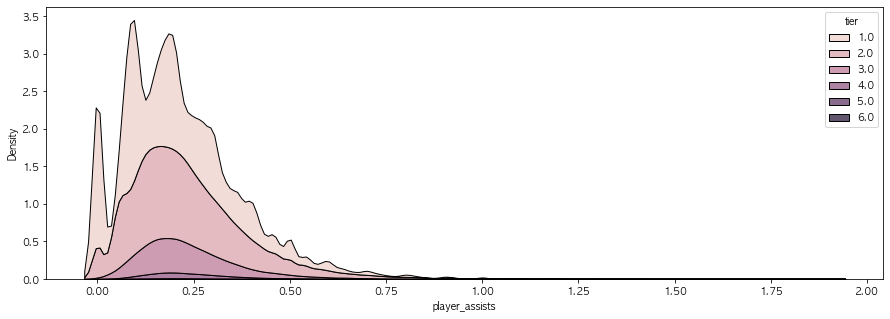

In [468]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='player_assists', hue='tier', multiple='stack')

In [469]:
duo_c['player_assists']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.020129
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.005776,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.000000,0.005776,1.000000,1.000000,1.000000
6.0,0.020129,1.000000,1.000000,1.000000,1.000000,1.000000


### player_dbno

In [470]:
get_tier_median(duo, 'player_dbno')

,player_dbno
tier,
1.000,0.462
2.000,0.545
3.000,0.568
4.000,0.596
5.000,0.598
6.000,0.566


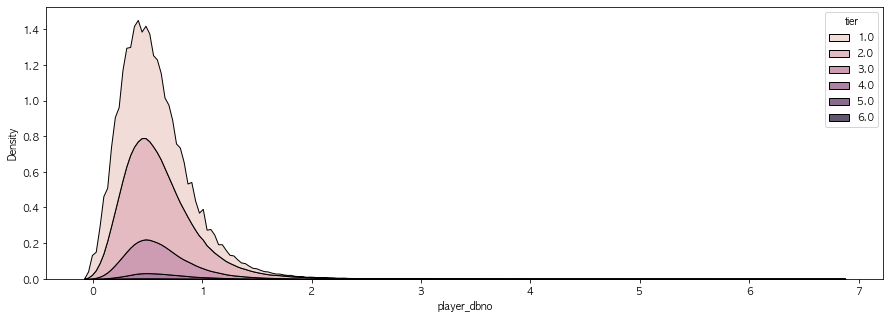

In [471]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='player_dbno', hue='tier', multiple='stack')

In [472]:
duo_c['player_dbno']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.007709
2.0,0.000000,1.000000,0.000000,0.000000,0.000001,1.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.019038,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.000001,0.019038,1.000000,1.000000,1.000000
6.0,0.007709,1.000000,1.000000,1.000000,1.000000,1.000000


### kda

In [473]:
get_tier_median(duo, 'kda')

,kda
tier,
1.000,0.857
2.000,1.048
3.000,1.071
4.000,1.139
5.000,1.140
6.000,1.025


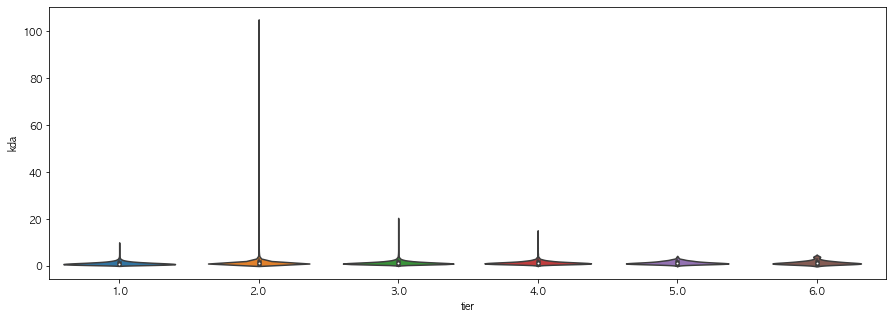

In [474]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=duo, x='tier', y='kda')

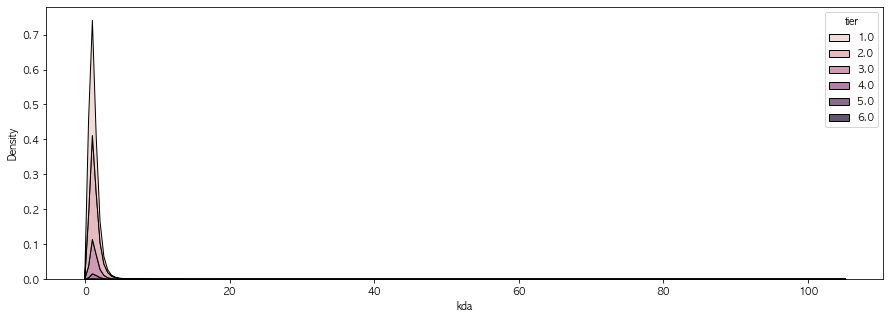

In [475]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='kda', hue='tier', multiple='stack')

In [476]:
duo_c['kda']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.001947
2.0,0.000000,1.000000,0.000000,0.000000,0.000003,1.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.005725,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.000003,0.005725,1.000000,1.000000,1.000000
6.0,0.001947,1.000000,1.000000,1.000000,1.000000,1.000000


### player_dist_walk

In [477]:
get_tier_median(duo, 'player_dist_walk')

,player_dist_walk
tier,
1.000,1034.782
2.000,1194.965
3.000,1158.060
4.000,1136.630
5.000,1123.544
6.000,1125.339


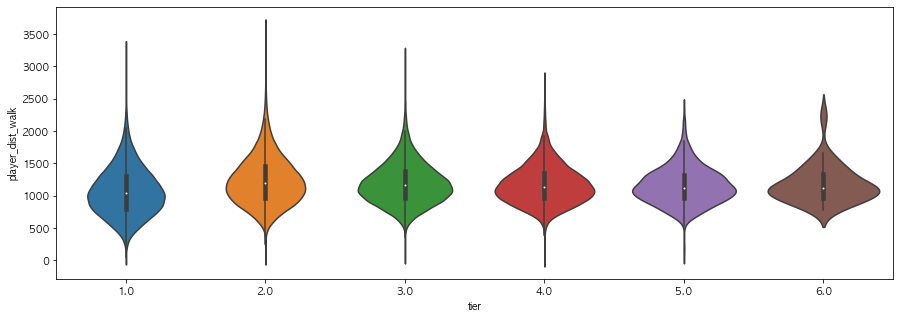

In [478]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=duo, x='tier', y='player_dist_walk')

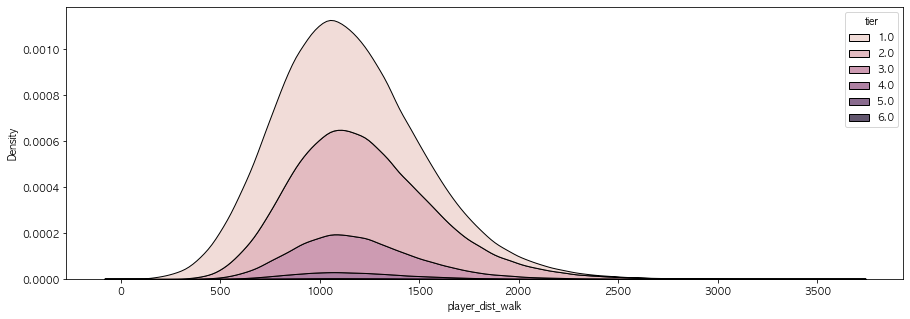

In [479]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='player_dist_walk', hue='tier', multiple='stack')

In [480]:
duo_c['player_dist_walk']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.093103
2.0,0.000000,1.000000,0.000000,0.000000,0.000024,1.000000
3.0,0.000000,0.000000,1.000000,0.000017,0.173994,1.000000
4.0,0.000000,0.000000,0.000017,1.000000,1.000000,1.000000
5.0,0.000000,0.000024,0.173994,1.000000,1.000000,1.000000
6.0,0.093103,1.000000,1.000000,1.000000,1.000000,1.000000


### player_dist_ride

In [481]:
get_tier_median(duo, 'player_dist_ride')

,player_dist_ride
tier,
1.000,872.725
2.000,1103.835
3.000,1116.022
4.000,1128.528
5.000,1106.568
6.000,972.556


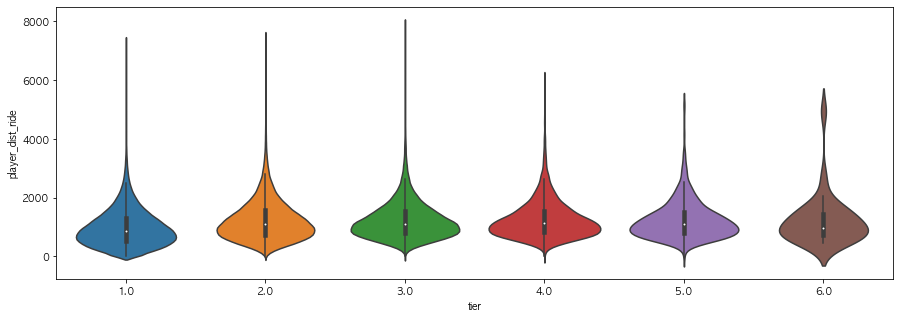

In [482]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=duo, x='tier', y='player_dist_ride')

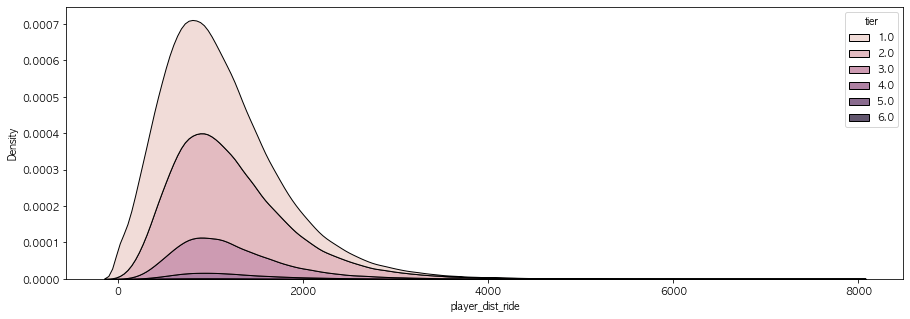

In [483]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='player_dist_ride', hue='tier', multiple='stack')

In [484]:
duo_c['player_dist_ride']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.134184
2.0,0.000000,1.000000,0.000000,0.000000,0.985476,1.000000
3.0,0.000000,0.000000,1.000000,0.001742,1.000000,1.000000
4.0,0.000000,0.000000,0.001742,1.000000,1.000000,1.000000
5.0,0.000000,0.985476,1.000000,1.000000,1.000000,1.000000
6.0,0.134184,1.000000,1.000000,1.000000,1.000000,1.000000


### kill_dist

In [485]:
get_tier_median(duo, 'kill_dist')

,kill_dist
tier,
1.000,2280.561
2.000,2880.650
3.000,2922.930
4.000,2922.688
5.000,2895.726
6.000,2855.483


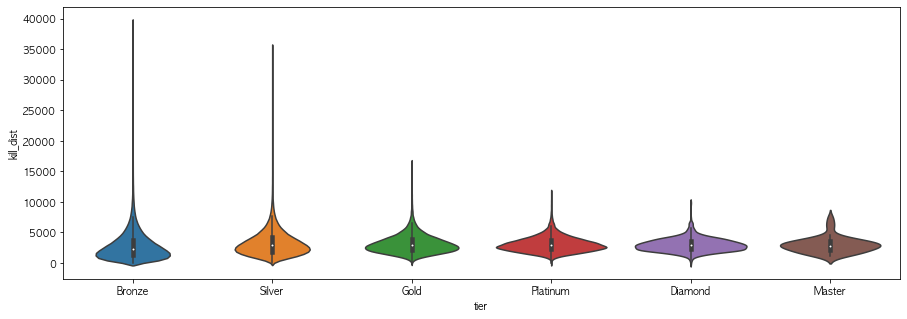

In [486]:
plt.figure(figsize=(15,5))
sns.violinplot(data=duo, x='tier', y='kill_dist')
_ = plt.xticks(np.arange(6), ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master'])

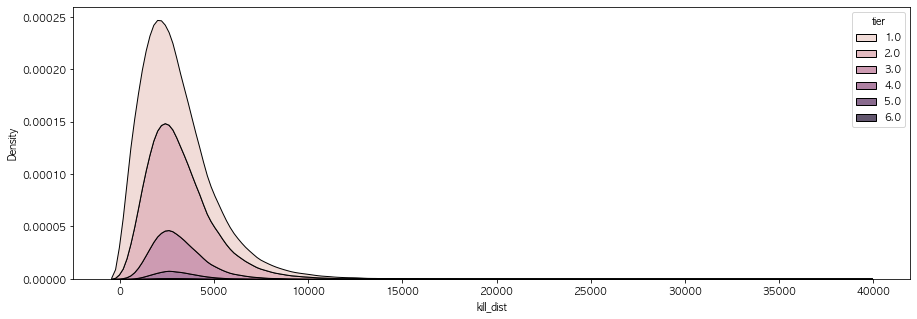

In [487]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='kill_dist', hue='tier', multiple='stack')

In [488]:
duo_c['kill_dist']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.160033
2.0,0.000000,1.000000,0.000000,0.000005,1.000000,1.000000
3.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
4.0,0.000000,0.000005,1.000000,1.000000,1.000000,1.000000
5.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6.0,0.160033,1.000000,1.000000,1.000000,1.000000,1.000000


### player_survive_time

In [489]:
get_tier_median(duo, 'player_survive_time')

,player_survive_time
tier,
1.000,675.840
2.000,766.940
3.000,753.733
4.000,749.568
5.000,750.351
6.000,731.760


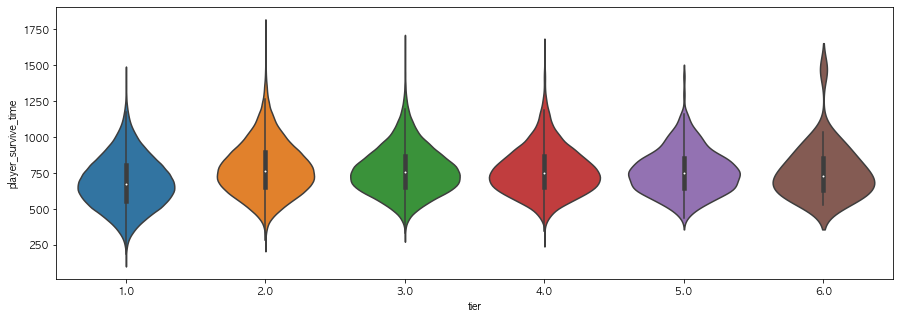

In [490]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=duo, x='tier', y='player_survive_time')

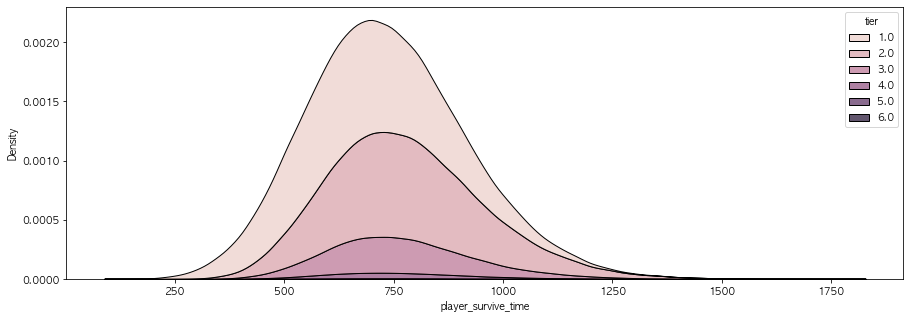

In [491]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=duo, x='player_survive_time', hue='tier', multiple='stack')

In [492]:
duo_c['player_survive_time']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.055919
2.0,0.000000,1.000000,0.000000,0.000000,0.086435,1.000000
3.0,0.000000,0.000000,1.000000,0.865442,1.000000,1.000000
4.0,0.000000,0.000000,0.865442,1.000000,1.000000,1.000000
5.0,0.000000,0.086435,1.000000,1.000000,1.000000,1.000000
6.0,0.055919,1.000000,1.000000,1.000000,1.000000,1.000000


### team_placement

In [493]:
get_tier_median(duo, 'team_placement')

,team_placement
tier,
1.000,26.909
2.000,24.433
3.000,24.800
4.000,24.859
5.000,24.876
6.000,25.646


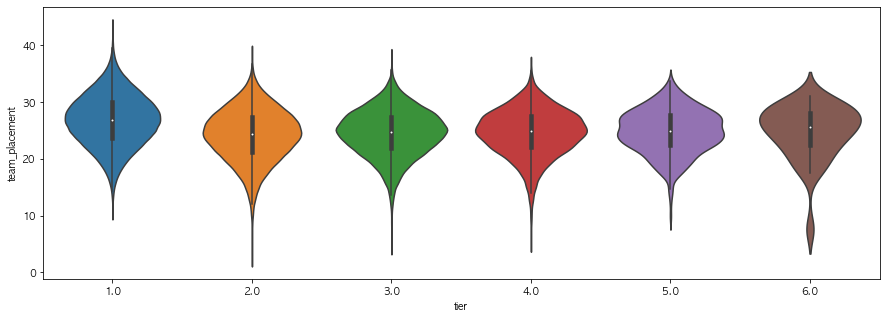

In [494]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=duo, x='tier', y='team_placement')

In [495]:
duo_c['team_placement']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.034776
2.0,0.000000,1.000000,0.000000,0.000000,0.010451,1.000000
3.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
4.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.010451,1.000000,1.000000,1.000000,1.000000
6.0,0.034776,1.000000,1.000000,1.000000,1.000000,1.000000


### num_of_match

In [496]:
get_tier_median(duo, 'num_of_match')

,num_of_match
tier,
1.000,12.000
2.000,20.000
3.000,41.000
4.000,82.000
5.000,170.000
6.000,360.000


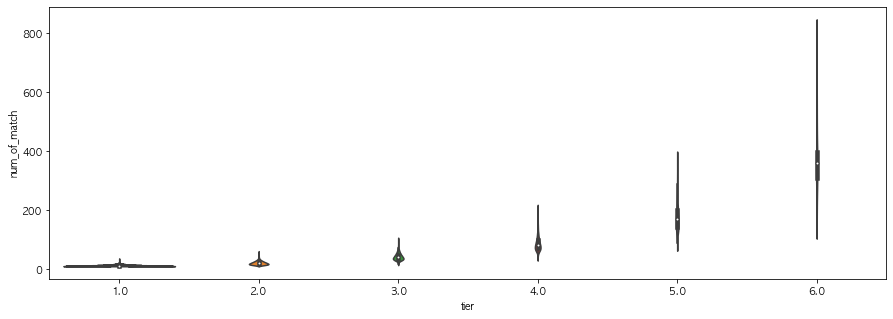

In [497]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=duo, x='tier', y='num_of_match')

In [498]:
duo_c['num_of_match']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000017
4.0,0.000000,0.000000,0.000000,1.000000,0.077227,0.976409
5.0,0.000000,0.000000,0.000000,0.077227,1.000000,0.976409
6.0,0.000000,0.000000,0.000017,0.976409,0.976409,1.000000


## Squad

In [499]:
squad = df_tier_diff[2]

In [500]:
squad_tier = get_tier_df(squad)

In [501]:
squad.corr().style.background_gradient(cmap='Blues')

,player_kills,player_dmg,player_assists,player_dbno,kda,player_dist_walk,player_dist_ride,kill_dist,player_survive_time,team_placement,num_of_match,tier
player_kills,1.000000,0.943047,0.447046,0.941941,0.947422,0.247525,0.128854,0.226618,0.233106,-0.211295,0.013409,0.120083
player_dmg,0.943047,1.000000,0.484022,0.948641,0.911150,0.271334,0.167397,0.251303,0.265998,-0.235387,0.014172,0.123909
player_assists,0.447046,0.484022,1.000000,0.409608,0.651343,0.271799,0.193939,0.189430,0.292667,-0.250058,0.012285,0.104083
player_dbno,0.941941,0.948641,0.409608,1.000000,0.884339,0.212216,0.116936,0.210966,0.196030,-0.173062,0.011041,0.108088
kda,0.947422,0.911150,0.651343,0.884339,1.000000,0.304970,0.184096,0.257633,0.306206,-0.281483,0.007816,0.123441
player_dist_walk,0.247525,0.271334,0.271799,0.212216,0.304970,1.000000,0.464237,0.314678,0.856794,-0.748166,-0.060632,0.085964
player_dist_ride,0.128854,0.167397,0.193939,0.116936,0.184096,0.464237,1.000000,0.233375,0.672462,-0.565621,0.004037,0.114416
kill_dist,0.226618,0.251303,0.189430,0.210966,0.257633,0.314678,0.233375,1.000000,0.332860,-0.305541,-0.024426,0.048572
player_survive_time,0.233106,0.265998,0.292667,0.196030,0.306206,0.856794,0.672462,0.332860,1.000000,-0.833211,-0.027116,0.134060
team_placement,-0.211295,-0.235387,-0.250058,-0.173062,-0.281483,-0.748166,-0.565621,-0.305541,-0.833211,1.000000,0.027296,-0.161946


In [502]:
squad.groupby('tier').median()

,player_kills,player_dmg,player_assists,player_dbno,kda,player_dist_walk,player_dist_ride,kill_dist,player_survive_time,team_placement,num_of_match
tier,,,,,,,,,,,
1.000,0.400,75.917,0.182,0.500,0.600,890.914,676.652,1522.072,591.962,17.700,10.000
2.000,0.700,109.692,0.267,0.700,1.000,1298.264,1150.197,2920.737,799.621,14.167,13.000
3.000,0.784,119.744,0.290,0.771,1.118,1314.305,1222.925,3261.787,814.747,13.944,26.000
4.000,0.800,121.714,0.294,0.786,1.132,1273.898,1229.590,3250.808,804.658,14.089,53.000
5.000,0.863,128.831,0.310,0.834,1.220,1261.095,1241.872,3223.618,804.082,14.052,107.000
6.000,0.907,132.376,0.316,0.867,1.257,1263.630,1224.708,3258.693,806.212,14.018,221.000


In [503]:
check_cols = squad.groupby('tier').mean().columns

squad_n, squad_k, squad_c = checking_tier_diff(squad, squad_tier, check_cols)

  0%|          | 0/11 [00:00<?, ?it/s]

In [504]:
# 정규성 검정 결과

squad_n

{'player_kills': [False, False, False, False, False, False],
 'player_dmg': [False, False, False, False, False, False],
 'player_assists': [False, False, False, False, False, False],
 'player_dbno': [False, False, False, False, False, False],
 'kda': [False, False, False, False, False, False],
 'player_dist_walk': [False, False, False, False, False, False],
 'player_dist_ride': [False, False, False, False, False, False],
 'kill_dist': [False, False, False, False, False, False],
 'player_survive_time': [False, False, False, False, False, False],
 'team_placement': [False, False, False, False, False, False],
 'num_of_match': [False, False, False, False, False, False]}

In [505]:
# Kruskal-Wallis 검정 결과

squad_k

{'player_kills': 0.0,
 'player_dmg': 0.0,
 'player_assists': 0.0,
 'player_dbno': 0.0,
 'kda': 0.0,
 'player_dist_walk': 0.0,
 'player_dist_ride': 0.0,
 'kill_dist': 0.0,
 'player_survive_time': 0.0,
 'team_placement': 0.0,
 'num_of_match': 0.0}

### player_kills

In [506]:
get_tier_median(squad, 'player_kills')

,player_kills
tier,
1.000,0.400
2.000,0.700
3.000,0.784
4.000,0.800
5.000,0.863
6.000,0.907


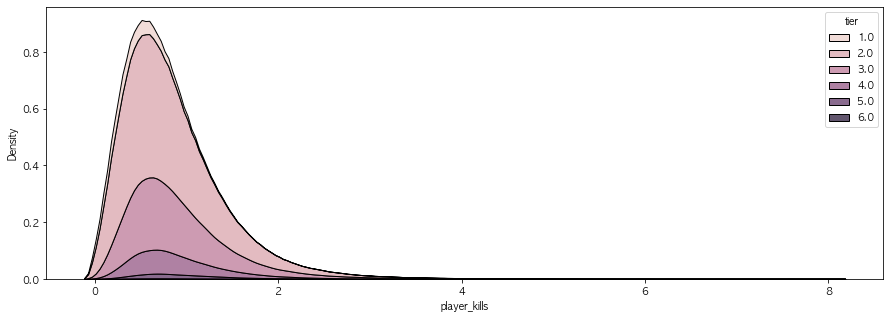

In [507]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='player_kills', hue='tier', multiple='stack')

In [508]:
squad_c['player_kills']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.008329
6.0,0.000000,0.000000,0.000000,0.000000,0.008329,1.000000


### player_dmg

In [509]:
get_tier_median(squad, 'player_dmg')

,player_dmg
tier,
1.000,75.917
2.000,109.692
3.000,119.744
4.000,121.714
5.000,128.831
6.000,132.376


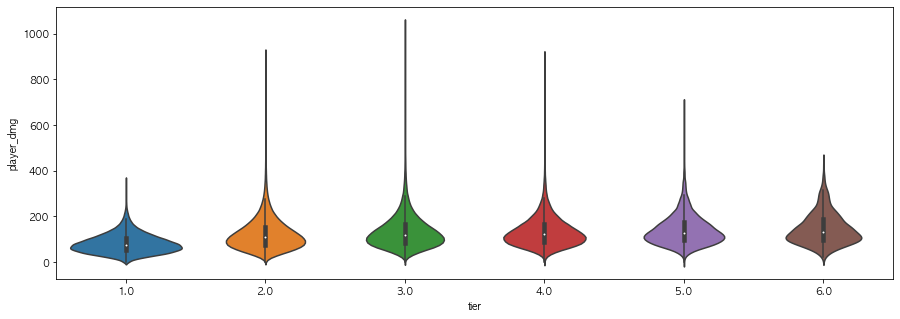

In [510]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=squad, x='tier', y='player_dmg')

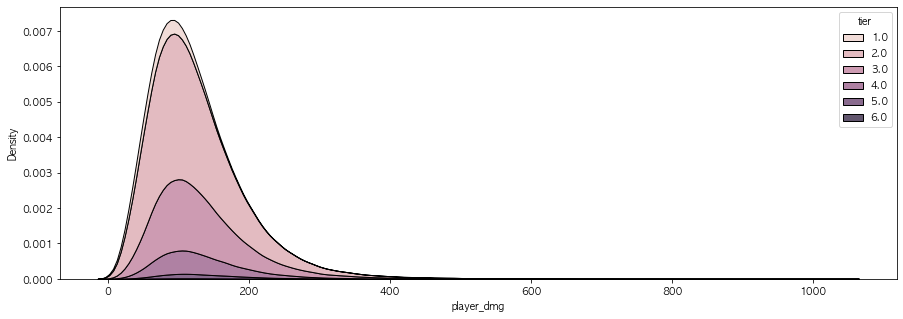

In [511]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='player_dmg', hue='tier', multiple='stack')

In [512]:
squad_c['player_dmg']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.028761
6.0,0.000000,0.000000,0.000000,0.000000,0.028761,1.000000


### player_assists

In [513]:
get_tier_median(squad, 'player_assists')

,player_assists
tier,
1.000,0.182
2.000,0.267
3.000,0.290
4.000,0.294
5.000,0.310
6.000,0.316


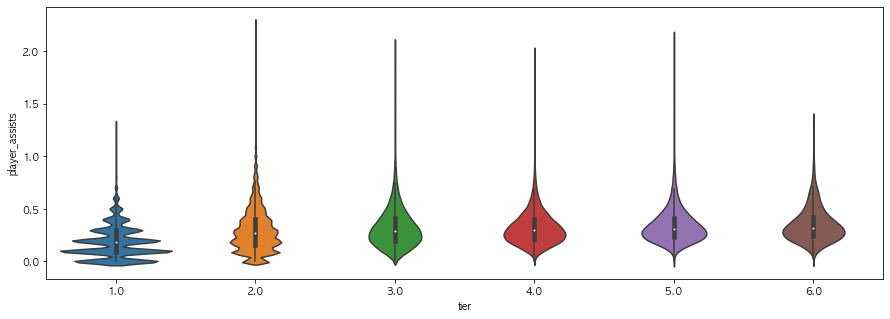

In [514]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=squad, x='tier', y='player_assists')

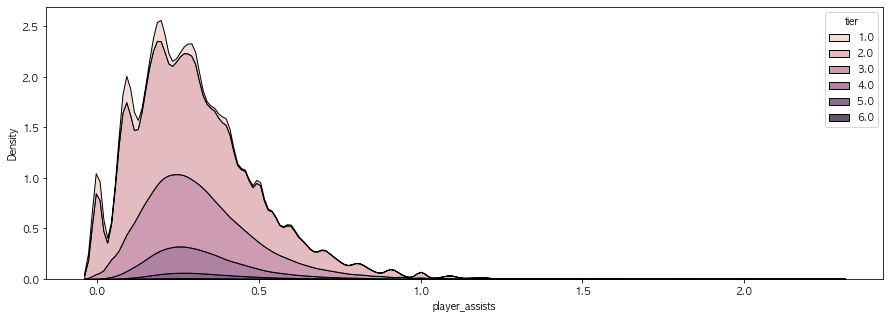

In [515]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='player_assists', hue='tier', multiple='stack')

In [516]:
squad_c['player_assists']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.032994
6.0,0.000000,0.000000,0.000000,0.000000,0.032994,1.000000


### player_dbno

In [517]:
get_tier_median(squad, 'player_dbno')

,player_dbno
tier,
1.000,0.500
2.000,0.700
3.000,0.771
4.000,0.786
5.000,0.834
6.000,0.867


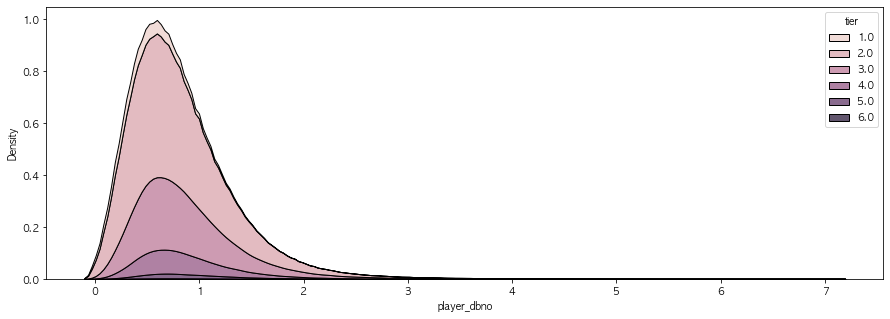

In [518]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='player_dbno', hue='tier', multiple='stack')

In [519]:
squad_c['player_dbno']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.016936
6.0,0.000000,0.000000,0.000000,0.000000,0.016936,1.000000


### kda

In [520]:
get_tier_median(squad, 'kda')

,kda
tier,
1.000,0.600
2.000,1.000
3.000,1.118
4.000,1.132
5.000,1.220
6.000,1.257


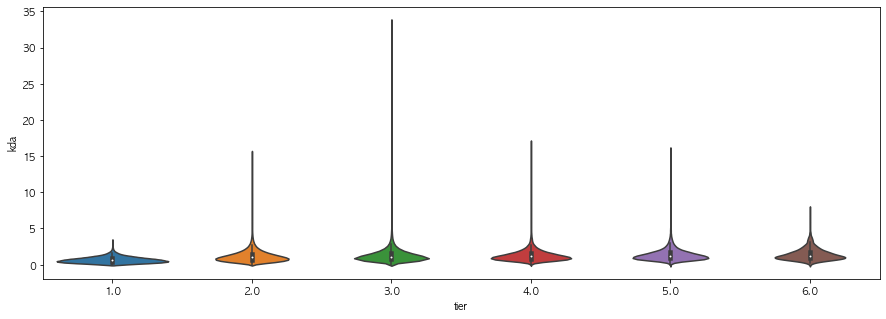

In [521]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=squad, x='tier', y='kda')

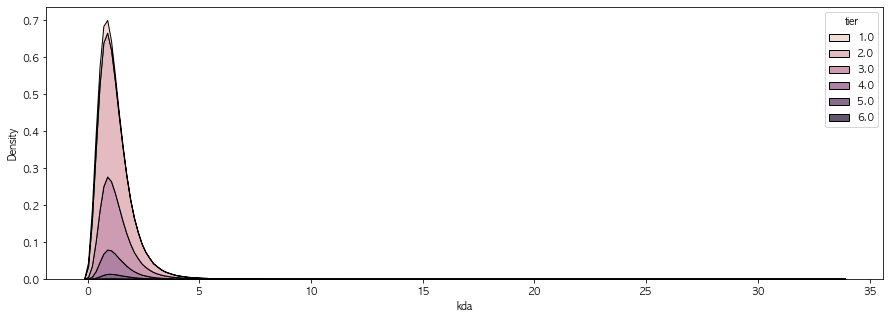

In [522]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='kda', hue='tier', multiple='stack')

In [523]:
squad_c['kda']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.010148
6.0,0.000000,0.000000,0.000000,0.000000,0.010148,1.000000


### player_dist_walk

In [524]:
get_tier_median(squad, 'player_dist_walk')

,player_dist_walk
tier,
1.000,890.914
2.000,1298.264
3.000,1314.305
4.000,1273.898
5.000,1261.095
6.000,1263.630


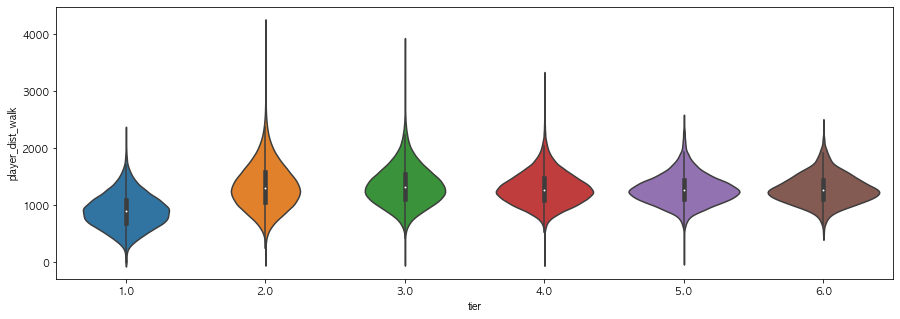

In [525]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=squad, x='tier', y='player_dist_walk')

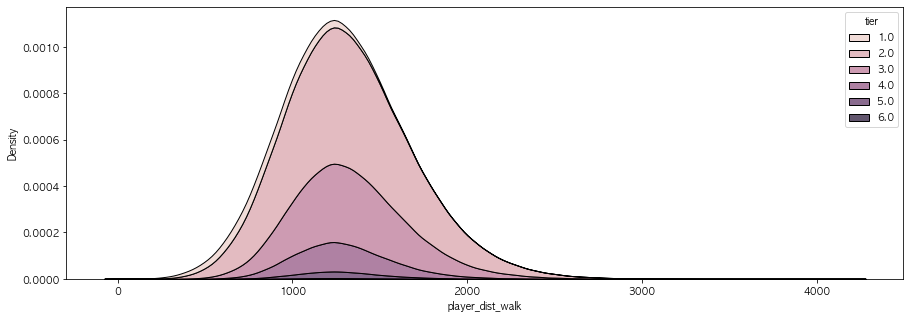

In [526]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='player_dist_walk', hue='tier', multiple='stack')

In [527]:
squad_c['player_dist_walk']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.017219
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000005
4.0,0.000000,0.000000,0.000000,1.000000,0.000257,0.932383
5.0,0.000000,0.000000,0.000000,0.000257,1.000000,0.932383
6.0,0.000000,0.017219,0.000005,0.932383,0.932383,1.000000


### player_dist_ride

In [528]:
get_tier_median(squad, 'player_dist_ride')

,player_dist_ride
tier,
1.000,676.652
2.000,1150.197
3.000,1222.925
4.000,1229.590
5.000,1241.872
6.000,1224.708


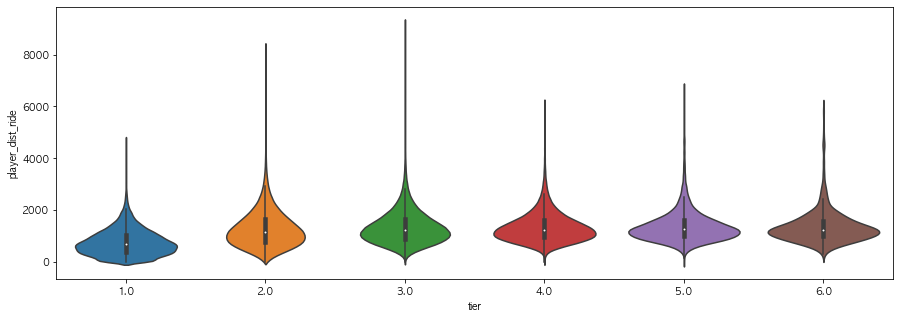

In [529]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=squad, x='tier', y='player_dist_ride')

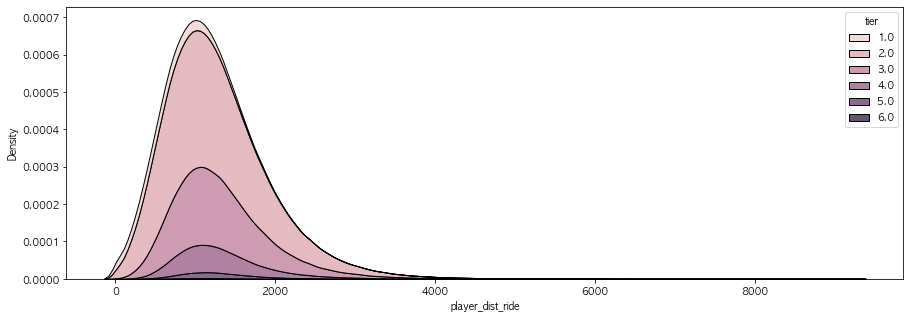

In [530]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='player_dist_ride', hue='tier', multiple='stack')

In [531]:
squad_c['player_dist_ride']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.186634
4.0,0.000000,0.000000,0.000000,1.000000,0.000022,0.685105
5.0,0.000000,0.000000,0.000000,0.000022,1.000000,0.685105
6.0,0.000000,0.000000,0.186634,0.685105,0.685105,1.000000


### kill_dist

In [532]:
get_tier_median(squad, 'kill_dist')

,kill_dist
tier,
1.000,1522.072
2.000,2920.737
3.000,3261.787
4.000,3250.808
5.000,3223.618
6.000,3258.693


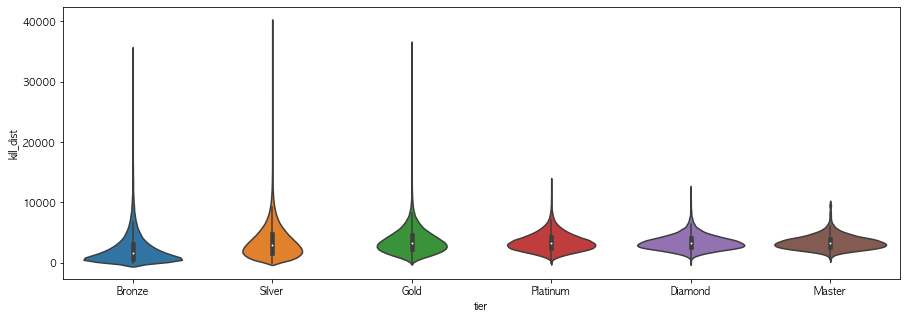

In [533]:
plt.figure(figsize=(15,5))
sns.violinplot(data=squad, x='tier', y='kill_dist')
_ = plt.xticks(np.arange(6), ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Master'])

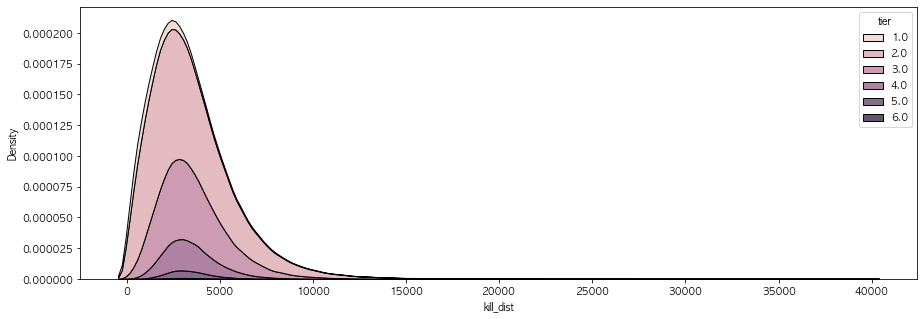

In [534]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='kill_dist', hue='tier', multiple='stack')

In [535]:
squad_c['kill_dist']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.287721,1.000000,1.000000
4.0,0.000000,0.000000,0.287721,1.000000,1.000000,1.000000
5.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
6.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000


### player_survive_time

In [536]:
get_tier_median(squad, 'player_survive_time')

,player_survive_time
tier,
1.000,591.962
2.000,799.621
3.000,814.747
4.000,804.658
5.000,804.082
6.000,806.212


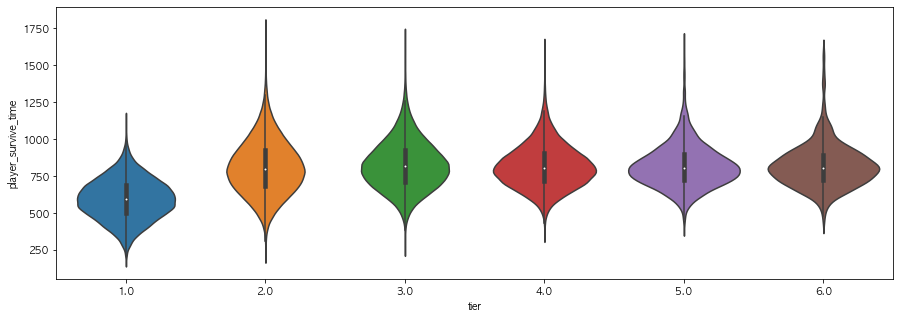

In [537]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=squad, x='tier', y='player_survive_time')

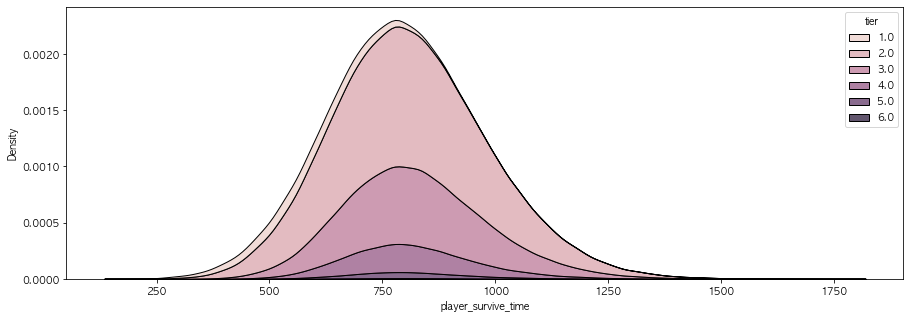

In [538]:
plt.figure(figsize=(15, 5))
_ = sns.kdeplot(data=squad, x='player_survive_time', hue='tier', multiple='stack')

In [539]:
squad_c['player_survive_time']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.036425
3.0,0.000000,0.000000,1.000000,0.000000,0.000157,1.000000
4.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
5.0,0.000000,0.000000,0.000157,1.000000,1.000000,1.000000
6.0,0.000000,0.036425,1.000000,1.000000,1.000000,1.000000


### team_placement

In [540]:
get_tier_median(squad, 'team_placement')

,team_placement
tier,
1.000,17.700
2.000,14.167
3.000,13.944
4.000,14.089
5.000,14.052
6.000,14.018


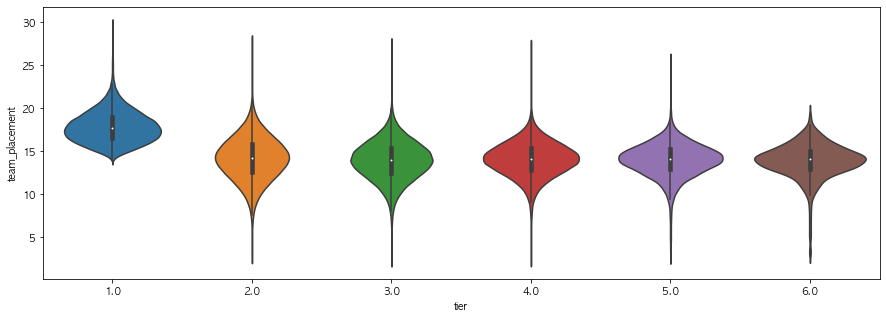

In [541]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=squad, x='tier', y='team_placement')

In [542]:
squad_c['team_placement']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.001333
3.0,0.000000,0.000000,1.000000,0.000000,0.006443,0.893831
4.0,0.000000,0.000000,0.000000,1.000000,0.006443,0.116704
5.0,0.000000,0.000000,0.006443,0.006443,1.000000,0.730709
6.0,0.000000,0.001333,0.893831,0.116704,0.730709,1.000000


### num_of_match

In [543]:
get_tier_median(squad, 'num_of_match')

,num_of_match
tier,
1.000,10.000
2.000,13.000
3.000,26.000
4.000,53.000
5.000,107.000
6.000,221.000


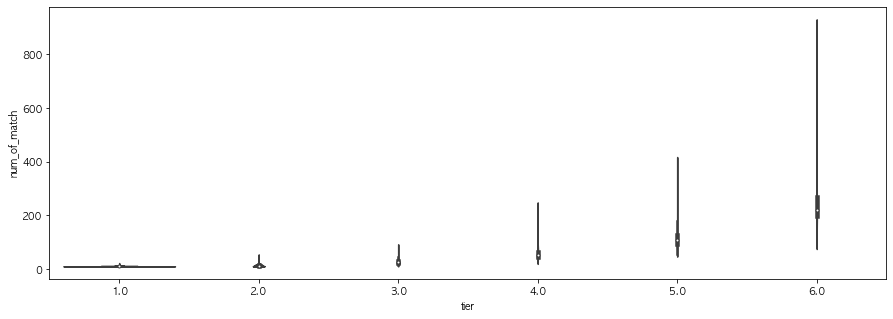

In [544]:
plt.figure(figsize=(15,5))
_ = sns.violinplot(data=squad, x='tier', y='num_of_match')

In [545]:
squad_c['num_of_match']

,1.0,2.0,3.0,4.0,5.0,6.0
1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
4.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.012939
6.0,0.000000,0.000000,0.000000,0.000000,0.012939,1.000000
